## Model Version 1
- Income estimator
- Random Forest regression as baseline
- lightgbm regression as final model


In [45]:
"""
INCOME ESTIMATION ML - PRODUCTION-READY DATA PREPARATION PIPELINE
================================================================

A comprehensive, clean solution for preparing income estimation datasets for ML training.
Designed for Caja Social (Panama Bank) with focus on interpretability and regulatory compliance.

Author: Income Estimation ML Team
Date: December 2024
Version: 1.0

Key Features:
- Customer-level data splitting (prevents data leakage)
- Target variable outlier detection and treatment
- Interpretable feature engineering with one-hot encoding
- Comprehensive data validation and ML-readiness checks
- Noise features for feature selection validation
- Production-ready with proper error handling

Usage:
    pipeline = IncomeEstimationPipeline()
    X_train, X_val, X_test, y_train, y_val, y_test = pipeline.run_full_pipeline(df)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Configure environment
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [46]:
class IncomeEstimationPipeline:
    """
    Complete pipeline for income estimation data preparation.
    Follows ML best practices and prevents data leakage.
    """
    
    def __init__(self, target_col='ingresos_reportados', random_state=42):
        """
        Initialize the pipeline.
        
        Args:
            target_col (str): Name of target variable column
            random_state (int): Random seed for reproducibility
        """
        self.target_col = target_col
        self.random_state = random_state
        self.fitted_transformers = {}
        self.outlier_thresholds = {}
        self.is_fitted = False
        
        # Define feature categories for interpretable modeling
        self.categorical_features = [
            'sexo_consolidated', 'estado_civil_consolidated', 'pais_consolidated',
            'ocupacion_consolidated', 'ciudad_consolidated', 'nombreempleadorcliente_consolidated',
            'cargoempleocliente_consolidated', 'age_group', 'segmento'
        ]
        
        self.numerical_features = [
            'edad', 'monto_letra', 'saldo', 'payment_to_income_ratio',
            'total_payment_to_income_ratio', 'debt_to_income_ratio',
            'relationship_tenure_years', 'num_products', 'product_diversity'
        ]
        
        self.binary_features = [
            'missing_fechaingresoempleo', 'missing_nombreempleadorcliente',
            'missing_cargoempleocliente', 'is_retired', 'high_value_customer',
            'customer_segment', 'letras_mensuales'
        ]
        
        print("🏗️ Income Estimation Pipeline Initialized")
        print(f"🎯 Target variable: {self.target_col}")
        print(f"📊 Feature categories: {len(self.categorical_features)} categorical, "
              f"{len(self.numerical_features)} numerical, {len(self.binary_features)} binary")
    
    def run_full_pipeline(self, df, customer_id_col='identificador_unico', 
                         train_size=0.7, val_size=0.2, test_size=0.1,
                         outlier_treatment='cap', save_outputs=True, output_dir='data/processed'):
        """
        Run the complete data preparation pipeline.
        
        Args:
            df (pd.DataFrame): Input dataset
            customer_id_col (str): Customer ID column name
            train_size (float): Training set proportion
            val_size (float): Validation set proportion  
            test_size (float): Test set proportion
            outlier_treatment (str): 'cap', 'flag', or 'none'
            save_outputs (bool): Whether to save processed datasets
            output_dir (str): Directory to save outputs
            
        Returns:
            tuple: (X_train, X_val, X_test, y_train, y_val, y_test)
        """
        
        print("🚀 STARTING INCOME ESTIMATION DATA PIPELINE")
        print("=" * 60)
        print(f"📊 Input dataset shape: {df.shape}")
        print(f"🎯 Target variable: {self.target_col}")
        print(f"👥 Unique customers: {df[customer_id_col].nunique()}")
        
        # Step 1: Customer-level data splitting
        print(f"\n📋 STEP 1: CUSTOMER-LEVEL DATA SPLITTING")
        train_df, val_df, test_df = self._split_data_by_customer(
            df, customer_id_col, train_size, val_size, test_size
        )
        
        # Step 2: Target variable analysis and treatment
        print(f"\n📋 STEP 2: TARGET VARIABLE ANALYSIS & TREATMENT")
        y_train_raw = train_df[self.target_col]
        y_val_raw = val_df[self.target_col]
        y_test_raw = test_df[self.target_col]
        
        # Analyze and treat outliers
        self.outlier_thresholds = self._analyze_target_variable(y_train_raw)
        y_train, y_val, y_test = self._apply_outlier_treatment(
            y_train_raw, y_val_raw, y_test_raw, outlier_treatment
        )
        
        # Step 3: Feature engineering
        print(f"\n📋 STEP 3: INTERPRETABLE FEATURE ENGINEERING")
        X_train = self._fit_transform_features(train_df)
        X_val = self._transform_features(val_df, "VALIDATION")
        X_test = self._transform_features(test_df, "TEST")
        
        # Step 4: Data cleaning and validation
        print(f"\n📋 STEP 4: DATA CLEANING & ML READINESS")
        X_train, X_val, X_test = self._clean_for_ml_training(X_train, X_val, X_test)
        
        # Step 5: Add noise features for feature selection
        print(f"\n📋 STEP 5: ADDING NOISE FEATURES FOR FEATURE SELECTION")
        X_train = self._add_noise_features(X_train)
        
        # Step 6: Final validation
        print(f"\n📋 STEP 6: FINAL VALIDATION & SUMMARY")
        self._validate_final_datasets(X_train, X_val, X_test, y_train, y_val, y_test)
        
        # Step 7: Save outputs (optional)
        if save_outputs:
            print(f"\n📋 STEP 7: SAVING PROCESSED DATASETS")
            self._save_processed_datasets(
                X_train, X_val, X_test, y_train, y_val, y_test, output_dir
            )
        
        print(f"\n✅ PIPELINE COMPLETED SUCCESSFULLY!")
        print(f"🎯 Ready for model training with interpretable features")
        
        return X_train, X_val, X_test, y_train, y_val, y_test

    def _split_data_by_customer(self, df, customer_id_col, train_size, val_size, test_size):
        """
        Split data ensuring no customer appears in multiple sets.
        Prevents data leakage by customer-level separation.
        """
        print(f"📊 Original dataset shape: {df.shape}")
        print(f"👥 Total unique customers: {df[customer_id_col].nunique()}")

        # Get unique customer IDs and shuffle
        unique_customers = df[customer_id_col].unique()
        np.random.seed(self.random_state)
        np.random.shuffle(unique_customers)

        # Calculate split indices
        n_customers = len(unique_customers)
        train_end = int(n_customers * train_size)
        val_end = int(n_customers * (train_size + val_size))

        # Split customer IDs
        train_customers = unique_customers[:train_end]
        val_customers = unique_customers[train_end:val_end]
        test_customers = unique_customers[val_end:]

        # Create data splits
        train_df = df[df[customer_id_col].isin(train_customers)].copy()
        val_df = df[df[customer_id_col].isin(val_customers)].copy()
        test_df = df[df[customer_id_col].isin(test_customers)].copy()

        # Verification and reporting
        print(f"✅ DATA SPLIT SUMMARY:")
        print(f"   Training: {train_df.shape[0]} samples ({len(train_df)/len(df)*100:.1f}%)")
        print(f"   Validation: {val_df.shape[0]} samples ({len(val_df)/len(df)*100:.1f}%)")
        print(f"   Test: {test_df.shape[0]} samples ({len(test_df)/len(df)*100:.1f}%)")

        # Data leakage verification
        train_customers_set = set(train_df[customer_id_col])
        val_customers_set = set(val_df[customer_id_col])
        test_customers_set = set(test_df[customer_id_col])

        overlaps = [
            len(train_customers_set.intersection(val_customers_set)),
            len(train_customers_set.intersection(test_customers_set)),
            len(val_customers_set.intersection(test_customers_set))
        ]

        if sum(overlaps) == 0:
            print(f"🔒 DATA LEAKAGE CHECK: ✅ PASSED - No customer overlap between sets")
        else:
            print(f"🔒 DATA LEAKAGE CHECK: ❌ FAILED - Customer overlap detected!")
            raise ValueError("Data leakage detected: customers appear in multiple sets")

        return train_df, val_df, test_df

    def _analyze_target_variable(self, y_train):
        """
        Comprehensive target variable analysis fitted on training data only.
        Returns outlier thresholds for consistent treatment across all sets.
        """
        print(f"🎯 TARGET VARIABLE ANALYSIS: {self.target_col}")
        print(f"📊 Training set: {len(y_train)} samples")

        # Basic statistics
        stats_summary = {
            'count': len(y_train),
            'mean': y_train.mean(),
            'median': y_train.median(),
            'std': y_train.std(),
            'min': y_train.min(),
            'max': y_train.max()
        }

        print(f"📈 BASIC STATISTICS:")
        print(f"   Mean: ${stats_summary['mean']:,.2f}")
        print(f"   Median: ${stats_summary['median']:,.2f}")
        print(f"   Range: ${stats_summary['min']:,.2f} - ${stats_summary['max']:,.2f}")

        # Outlier detection using multiple methods
        # Method 1: IQR Method
        Q1 = y_train.quantile(0.25)
        Q3 = y_train.quantile(0.75)
        IQR = Q3 - Q1
        iqr_lower = Q1 - 1.5 * IQR
        iqr_upper = Q3 + 1.5 * IQR
        iqr_outliers = y_train[(y_train < iqr_lower) | (y_train > iqr_upper)]

        # Method 2: Percentile Method (Conservative)
        perc_lower = np.percentile(y_train, 1)
        perc_upper = np.percentile(y_train, 99)
        perc_outliers = y_train[(y_train < perc_lower) | (y_train > perc_upper)]

        outlier_pct = len(iqr_outliers) / len(y_train) * 100

        print(f"🔍 OUTLIER ANALYSIS:")
        print(f"   IQR Method: {len(iqr_outliers)} outliers ({outlier_pct:.1f}%)")
        print(f"   Percentile Method: {len(perc_outliers)} outliers")
        print(f"   IQR bounds: ${iqr_lower:,.2f} - ${iqr_upper:,.2f}")
        print(f"   Percentile bounds: ${perc_lower:,.2f} - ${perc_upper:,.2f}")

        # Income distribution analysis for panama market
        income_ranges = {
            'very_low': (y_train <= 1000000).sum(),
            'low': ((y_train > 1000000) & (y_train <= 3000000)).sum(),
            'medium': ((y_train > 3000000) & (y_train <= 10000000)).sum(),
            'high': ((y_train > 10000000) & (y_train <= 20000000)).sum(),
            'very_high': (y_train > 20000000).sum()
        }

        print(f"💰 INCOME DISTRIBUTION (Panama Market):")
        for range_name, count in income_ranges.items():
            pct = count / len(y_train) * 100
            print(f"   {range_name.replace('_', ' ').title()}: {count} ({pct:.1f}%)")

        # Recommendations
        print(f"💡 RECOMMENDATIONS:")
        if outlier_pct > 10:
            print(f"   ⚠️  High outlier percentage - recommend capping at percentiles")
            recommended_method = 'percentile'
        else:
            print(f"   ✅ Moderate outliers - IQR method suitable")
            recommended_method = 'iqr'

        # Return thresholds fitted on training data
        return {
            'iqr_lower': iqr_lower,
            'iqr_upper': iqr_upper,
            'percentile_lower': perc_lower,
            'percentile_upper': perc_upper,
            'method_recommended': recommended_method,
            'stats': stats_summary
        }

    def _apply_outlier_treatment(self, y_train, y_val, y_test, method='cap'):
        """
        Apply outlier treatment using thresholds fitted on training data.
        Ensures consistent treatment across all datasets.
        """
        print(f"🔧 APPLYING OUTLIER TREATMENT: {method.upper()}")

        if method == 'none':
            print(f"   No treatment applied - using original values")
            return y_train.copy(), y_val.copy(), y_test.copy()

        # Get fitted thresholds
        recommended_method = self.outlier_thresholds['method_recommended']
        lower_bound = self.outlier_thresholds[f'{recommended_method}_lower']
        upper_bound = self.outlier_thresholds[f'{recommended_method}_upper']

        print(f"   Using {recommended_method.upper()} method")
        print(f"   Bounds: ${lower_bound:,.2f} - ${upper_bound:,.2f}")

        if method == 'cap':
            # Winsorization (capping extreme values)
            y_train_clean = y_train.clip(lower_bound, upper_bound)
            y_val_clean = y_val.clip(lower_bound, upper_bound)
            y_test_clean = y_test.clip(lower_bound, upper_bound)

            print(f"   ✅ Capped outliers to bounds")

        elif method == 'flag':
            # Keep original values but could add outlier flags as features
            y_train_clean = y_train.copy()
            y_val_clean = y_val.copy()
            y_test_clean = y_test.copy()

            train_outliers = (y_train < lower_bound) | (y_train > upper_bound)
            print(f"   ✅ Flagged {train_outliers.sum()} outliers (no capping applied)")

        # Show treatment impact
        print(f"📊 TREATMENT IMPACT:")
        print(f"   Before: mean=${y_train.mean():,.2f}, std=${y_train.std():,.2f}")
        print(f"   After:  mean=${y_train_clean.mean():,.2f}, std=${y_train_clean.std():,.2f}")

        return y_train_clean, y_val_clean, y_test_clean

    def _fit_transform_features(self, train_df):
        """
        Fit feature engineering transformers on training data and transform.
        Uses interpretable one-hot encoding approach.
        """
        print(f"🔧 FITTING FEATURE ENGINEERING ON TRAINING DATA")
        print(f"📊 Input shape: {train_df.shape}")

        # Fit categorical encoders
        self._fit_categorical_encoders(train_df)

        # Fit numerical scalers
        self._fit_numerical_scalers(train_df)

        # Fit interaction feature parameters
        self._fit_interaction_features(train_df)

        self.is_fitted = True

        # Transform training data
        return self._transform_features(train_df, "TRAINING")

    def _transform_features(self, df, dataset_name="DATASET"):
        """
        Transform features using fitted parameters.
        Can be applied to train, validation, or test sets.
        """
        print(f"🔄 TRANSFORMING {dataset_name} DATA")
        print(f"📊 Input shape: {df.shape}")

        if not self.is_fitted:
            raise ValueError("❌ Must fit transformers first!")

        df_transformed = df.copy()

        # Apply transformations
        df_transformed = self._transform_categorical_features(df_transformed)
        df_transformed = self._transform_numerical_features(df_transformed)
        df_transformed = self._create_interaction_features(df_transformed)

        # Remove ID columns and target for feature matrix
        feature_cols = [col for col in df_transformed.columns
                       if col not in ['identificador_unico', 'cliente', self.target_col]]

        X = df_transformed[feature_cols]

        print(f"📈 Output shape: {X.shape}")
        return X

    def _fit_categorical_encoders(self, train_df):
        """Fit one-hot encoders for categorical features."""
        print(f"📋 Fitting categorical encoders...")

        for feature in self.categorical_features:
            if feature in train_df.columns:
                unique_categories = sorted(train_df[feature].dropna().unique())
                self.fitted_transformers[f'{feature}_categories'] = unique_categories

                if len(unique_categories) > 20:
                    print(f"   ⚠️  {feature}: {len(unique_categories)} categories (high cardinality)")
                else:
                    print(f"   ✅ {feature}: {len(unique_categories)} categories")

    def _transform_categorical_features(self, df):
        """Transform categorical features using one-hot encoding."""
        df_cat = df.copy()

        for feature in self.categorical_features:
            if feature in df_cat.columns:
                fitted_categories = self.fitted_transformers.get(f'{feature}_categories', [])

                if fitted_categories:
                    # Handle missing values and unknown categories
                    df_cat[feature] = df_cat[feature].fillna('Missing')
                    mask_unknown = ~df_cat[feature].isin(fitted_categories)

                    if mask_unknown.any():
                        df_cat.loc[mask_unknown, feature] = 'Unknown'

                    # One-hot encode
                    for category in fitted_categories:
                        df_cat[f'{feature}_{category}'] = (df_cat[feature] == category).astype(int)

                    # Add Unknown category if needed
                    if mask_unknown.any():
                        df_cat[f'{feature}_Unknown'] = (df_cat[feature] == 'Unknown').astype(int)

                    # Drop original column
                    df_cat = df_cat.drop(columns=[feature])

        return df_cat

    def _fit_numerical_scalers(self, train_df):
        """Fit scalers for numerical features."""
        print(f"🔢 Fitting numerical scalers...")

        for feature in self.numerical_features:
            if feature in train_df.columns:
                scaler = StandardScaler()
                scaler.fit(train_df[[feature]])
                self.fitted_transformers[f'{feature}_scaler'] = scaler

                # Store statistics for interpretability
                self.fitted_transformers[f'{feature}_stats'] = {
                    'mean': train_df[feature].mean(),
                    'std': train_df[feature].std()
                }

        print(f"   ✅ Fitted {len(self.numerical_features)} numerical scalers")

    def _transform_numerical_features(self, df):
        """Transform numerical features using fitted scalers."""
        df_num = df.copy()

        for feature in self.numerical_features:
            if feature in df_num.columns:
                scaler = self.fitted_transformers.get(f'{feature}_scaler')
                if scaler is not None:
                    df_num[f'{feature}_scaled'] = scaler.transform(df_num[[feature]]).flatten()

        return df_num

    def _fit_interaction_features(self, train_df):
        """Fit parameters for interpretable interaction features."""
        print(f"🔗 Fitting interaction feature parameters...")

        # Financial capacity statistics
        if 'saldo' in train_df.columns and 'monto_letra' in train_df.columns:
            capacity_ratio = train_df['saldo'] / (train_df['monto_letra'] + 1)
            self.fitted_transformers['capacity_stats'] = {
                'median': capacity_ratio.median()
            }

        print(f"   ✅ Fitted interaction parameters")

    def _create_interaction_features(self, df):
        """Create interpretable interaction features."""
        df_int = df.copy()

        # Age-based interactions
        if 'edad' in df_int.columns:
            df_int['is_young_adult'] = ((df_int['edad'] >= 18) & (df_int['edad'] <= 30)).astype(int)
            df_int['is_middle_aged'] = ((df_int['edad'] >= 31) & (df_int['edad'] <= 50)).astype(int)
            df_int['is_senior'] = (df_int['edad'] >= 51).astype(int)

        # Financial health indicators
        if 'saldo' in df_int.columns and 'monto_letra' in df_int.columns:
            df_int['financial_capacity_ratio'] = df_int['saldo'] / (df_int['monto_letra'] + 1)

            capacity_stats = self.fitted_transformers.get('capacity_stats', {'median': 1.0})
            df_int['has_good_financial_capacity'] = (
                df_int['financial_capacity_ratio'] > capacity_stats['median']
            ).astype(int)

        # Employment stability
        if 'relationship_tenure_years' in df_int.columns:
            df_int['is_long_term_customer'] = (df_int['relationship_tenure_years'] >= 3).astype(int)
            df_int['is_new_customer'] = (df_int['relationship_tenure_years'] <= 1).astype(int)

        # Debt burden categories
        if 'debt_to_income_ratio' in df_int.columns:
            df_int['has_low_debt_burden'] = (df_int['debt_to_income_ratio'] <= 0.3).astype(int)
            df_int['has_high_debt_burden'] = (df_int['debt_to_income_ratio'] >= 0.5).astype(int)

        return df_int

    def _clean_for_ml_training(self, X_train, X_val, X_test):
        """Remove non-ML compatible columns and verify data quality."""
        print(f"🧹 CLEANING DATASETS FOR ML TRAINING")

        # Identify columns to remove
        columns_to_remove = []

        # Object/string columns (non-encoded categorical)
        object_columns = X_train.select_dtypes(include=['object']).columns.tolist()
        columns_to_remove.extend(object_columns)

        # Date columns
        date_columns = X_train.select_dtypes(include=['datetime64']).columns.tolist()
        columns_to_remove.extend(date_columns)

        # ID columns
        id_patterns = ['id', 'identificador', 'cliente']
        id_columns = [col for col in X_train.columns
                      if any(pattern in col.lower() for pattern in id_patterns)]
        columns_to_remove.extend(id_columns)

        # Target column (if accidentally included)
        target_columns = [col for col in X_train.columns
                         if self.target_col.lower() in col.lower()]
        columns_to_remove.extend(target_columns)

        # Remove duplicates
        columns_to_remove = list(set(columns_to_remove))

        if columns_to_remove:
            print(f"   🗑️  Removing {len(columns_to_remove)} non-ML columns")
            X_train_clean = X_train.drop(columns=columns_to_remove, errors='ignore')
            X_val_clean = X_val.drop(columns=columns_to_remove, errors='ignore')
            X_test_clean = X_test.drop(columns=columns_to_remove, errors='ignore')
        else:
            X_train_clean, X_val_clean, X_test_clean = X_train, X_val, X_test

        # Verify data types
        non_numeric_cols = X_train_clean.select_dtypes(exclude=['number', 'bool']).columns.tolist()
        if non_numeric_cols:
            print(f"   ⚠️  WARNING: Non-numeric columns found: {non_numeric_cols}")
        else:
            print(f"   ✅ All features are numeric/boolean")

        print(f"   📊 Final shapes: Train={X_train_clean.shape}, Val={X_val_clean.shape}, Test={X_test_clean.shape}")

        return X_train_clean, X_val_clean, X_test_clean

    def _add_noise_features(self, X_train):
        """Add noise features for feature selection validation."""
        print(f"🎲 ADDING NOISE FEATURES FOR FEATURE SELECTION")

        np.random.seed(self.random_state)
        data_size = len(X_train)

        # Create various types of noise features
        noise_features = {
            'noise_gaussian_low': np.random.normal(0, 1000, size=data_size),
            'noise_gaussian_med': np.random.normal(0, 5000, size=data_size),
            'noise_gaussian_high': np.random.normal(0, 10000, size=data_size),
            'noise_uniform': np.random.uniform(-20000, 20000, size=data_size),
            'noise_binary_1': np.random.choice([0, 1], size=data_size, p=[0.6, 0.4]),
            'noise_binary_2': np.random.choice([0, 1], size=data_size, p=[0.7, 0.3]),
            'noise_categorical_1': np.random.choice([0, 1, 2, 3, 4], size=data_size),
            'noise_ratio_1': np.random.uniform(0, 2, size=data_size),
            'noise_ratio_2': np.random.uniform(0, 1, size=data_size),
            'noise_interaction': np.random.normal(0, 1000, size=data_size) * np.random.normal(0, 1000, size=data_size)
        }

        # Add noise features to training set
        X_train_with_noise = X_train.copy()
        for feature_name, feature_values in noise_features.items():
            X_train_with_noise[feature_name] = feature_values

        print(f"   ✅ Added {len(noise_features)} noise features")
        print(f"   📊 Shape: {X_train.shape} → {X_train_with_noise.shape}")

        return X_train_with_noise

    def _validate_final_datasets(self, X_train, X_val, X_test, y_train, y_val, y_test):
        """Final validation of datasets for ML readiness."""
        print(f"🔍 FINAL VALIDATION & ML READINESS CHECK")

        # Shape consistency
        print(f"📊 DATASET SHAPES:")
        print(f"   Training: X={X_train.shape}, y={y_train.shape}")
        print(f"   Validation: X={X_val.shape}, y={y_val.shape}")
        print(f"   Test: X={X_test.shape}, y={y_test.shape}")

        # Missing values check
        missing_counts = [
            X_train.isnull().sum().sum(),
            X_val.isnull().sum().sum(),
            X_test.isnull().sum().sum()
        ]

        print(f"📊 MISSING VALUES: Train={missing_counts[0]}, Val={missing_counts[1]}, Test={missing_counts[2]}")

        # Data types check
        non_numeric = X_train.select_dtypes(exclude=['number', 'bool']).columns
        if len(non_numeric) == 0:
            print(f"✅ DATA TYPES: All features are numeric/boolean - ML ready!")
        else:
            print(f"❌ DATA TYPES: Non-numeric columns found: {non_numeric.tolist()}")

        # Feature breakdown
        real_features = [col for col in X_train.columns if not col.startswith('noise_')]
        noise_features = [col for col in X_train.columns if col.startswith('noise_')]

        print(f"🔍 FEATURE BREAKDOWN:")
        print(f"   Real features: {len(real_features)}")
        print(f"   Noise features: {len(noise_features)}")
        print(f"   Total features: {X_train.shape[1]}")

        # Target variable summary
        print(f"💰 TARGET VARIABLE SUMMARY:")
        print(f"   Training mean: ${y_train.mean():,.2f}")
        print(f"   Training range: ${y_train.min():,.2f} - ${y_train.max():,.2f}")

    def _save_processed_datasets(self, X_train, X_val, X_test, y_train, y_val, y_test, output_dir):
        """Save processed datasets and transformers."""
        print(f"💾 SAVING PROCESSED DATASETS")

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Save feature matrices
        X_train.to_csv(f'{output_dir}/X_train_processed.csv', index=False)
        X_val.to_csv(f'{output_dir}/X_val_processed.csv', index=False)
        X_test.to_csv(f'{output_dir}/X_test_processed.csv', index=False)

        # Save target variables
        y_train.to_csv(f'{output_dir}/y_train_processed.csv', index=False)
        y_val.to_csv(f'{output_dir}/y_val_processed.csv', index=False)
        y_test.to_csv(f'{output_dir}/y_test_processed.csv', index=False)

        # Save transformers and thresholds
        pipeline_artifacts = {
            'fitted_transformers': self.fitted_transformers,
            'outlier_thresholds': self.outlier_thresholds,
            'feature_categories': {
                'categorical': self.categorical_features,
                'numerical': self.numerical_features,
                'binary': self.binary_features
            }
        }

        joblib.dump(pipeline_artifacts, f'{output_dir}/pipeline_artifacts.joblib')

        print(f"   ✅ Datasets saved to: {output_dir}")
        print(f"   ✅ Pipeline artifacts saved for production use")


In [47]:
# USAGE EXAMPLE AND MAIN EXECUTION
if __name__ == "__main__":
    """
    Example usage of the Income Estimation Pipeline
    """

    print("🚀 INCOME ESTIMATION ML - DATA PREPARATION PIPELINE")
    print("=" * 60)
    print(f"📅 Execution Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    # Configuration
    DATA_PATH = "C:/Users/david/OneDrive/Documents/augment-projects/caja-social/income-estimator-ml/data/processed/final_dataset.csv"
    OUTPUT_DIR = "C:/Users/david/OneDrive/Documents/augment-projects/caja-social/income-estimator-ml"

    try:
        # Load data
        print(f"\n📂 LOADING DATA FROM: {DATA_PATH}")
        df = pd.read_csv(DATA_PATH)
        print(f"✅ Data loaded successfully: {df.shape}")

        # Initialize and run pipeline
        pipeline = IncomeEstimationPipeline(
            target_col='ingresos_reportados',
            random_state=42
        )

        # Run complete pipeline
        X_train, X_val, X_test, y_train, y_val, y_test = pipeline.run_full_pipeline(
            df=df,
            customer_id_col='identificador_unico',
            train_size=0.7,
            val_size=0.2,
            test_size=0.1,
            outlier_treatment='cap',  # Options: 'cap', 'flag', 'none'
            save_outputs=True,
            output_dir=OUTPUT_DIR
        )

        print(f"\n🎉 PIPELINE COMPLETED SUCCESSFULLY!")
        print(f"📊 Final Output Shapes:")
        print(f"   X_train: {X_train.shape}")
        print(f"   X_val: {X_val.shape}")
        print(f"   X_test: {X_test.shape}")
        print(f"   y_train: {y_train.shape}")
        print(f"   y_val: {y_val.shape}")
        print(f"   y_test: {y_test.shape}")

        print(f"\n🎯 NEXT STEPS:")
        print(f"   1. Use the processed datasets for model training")
        print(f"   2. Apply feature selection using noise features as baseline")
        print(f"   3. Train interpretable models (Random Forest, Gradient Boosting)")
        print(f"   4. Validate model performance on test set")
        print(f"   5. Deploy model using saved pipeline artifacts")

    except FileNotFoundError:
        print(f"❌ ERROR: Data file not found at {DATA_PATH}")
        print(f"   Please update DATA_PATH to point to your dataset")
    except Exception as e:
        print(f"❌ ERROR: {str(e)}")
        print(f"   Please check your data and configuration")

🚀 INCOME ESTIMATION ML - DATA PREPARATION PIPELINE
📅 Execution Date: 2025-09-02 13:19:52

📂 LOADING DATA FROM: C:/Users/david/OneDrive/Documents/augment-projects/caja-social/income-estimator-ml/data/processed/final_dataset.csv
✅ Data loaded successfully: (15000, 39)
🏗️ Income Estimation Pipeline Initialized
🎯 Target variable: ingresos_reportados
📊 Feature categories: 9 categorical, 9 numerical, 7 binary
🚀 STARTING INCOME ESTIMATION DATA PIPELINE
📊 Input dataset shape: (15000, 39)
🎯 Target variable: ingresos_reportados
👥 Unique customers: 15000

📋 STEP 1: CUSTOMER-LEVEL DATA SPLITTING
📊 Original dataset shape: (15000, 39)
👥 Total unique customers: 15000
✅ DATA SPLIT SUMMARY:
   Training: 10500 samples (70.0%)
   Validation: 2999 samples (20.0%)
   Test: 1501 samples (10.0%)
🔒 DATA LEAKAGE CHECK: ✅ PASSED - No customer overlap between sets

📋 STEP 2: TARGET VARIABLE ANALYSIS & TREATMENT
🎯 TARGET VARIABLE ANALYSIS: ingresos_reportados
📊 Training set: 10500 samples
📈 BASIC STATISTICS:
   M

## Voting system

In [8]:
! pip install lightgbm

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import numpy as np
import pandas as pd

# FEATURE SELECTION VOTING SYSTEM FOR INCOME ESTIMATION
print("🗳️ FEATURE SELECTION VOTING SYSTEM - INCOME ESTIMATION")
print("=" * 60)

# Initialize regression models for SINGLE-TARGET prediction (income estimation)
# These models will help identify the best features vs noise features

# Model 1: Random Forest (excellent for feature importance)
model1 = RandomForestRegressor(
    n_estimators=200,           # More trees for better feature importance
    max_depth=10,               # Prevent overfitting
    min_samples_split=20,       # Conservative splitting
    min_samples_leaf=10,        # Conservative leaf size
    random_state=42,
    n_jobs=-1,                  # Use all available cores
    oob_score=True             # Out-of-bag score for validation
)

# Model 2: LightGBM (fast and effective for feature selection)
model2 = lgb.LGBMRegressor(
    n_estimators=200,           # Sufficient for feature importance
    max_depth=8,                # Prevent overfitting
    learning_rate=0.1,          # Conservative learning rate
    num_leaves=31,              # Default balanced value
    min_child_samples=20,       # Conservative splitting
    subsample=0.8,              # Feature bagging
    colsample_bytree=0.8,       # Column sampling
    random_state=42,
    n_jobs=-1,
    verbose=-1,                 # Suppress warnings
    importance_type='gain'      # Use gain for feature importance
)

# Model 3: Ridge Regression with built-in feature selection
model3 = Ridge(
    alpha=1.0,                  # Regularization strength
    random_state=42,
    max_iter=1000              # Ensure convergence
)

# Store models in a dictionary for easy iteration
models = {
    'RandomForest': model1,
    'LightGBM': model2, 
    'Ridge': model3
}

print("✅ Initialized models for income estimation feature selection:")
for name, model in models.items():
    print(f"   - {name}: {type(model).__name__}")

# FEATURE SELECTION METHODS FOR VOTING SYSTEM
print(f"\n🔍 FEATURE SELECTION METHODS:")

# Method 1: Statistical Feature Selection (F-test)
selector_f_test = SelectKBest(
    score_func=f_regression,
    k='all'  # Get scores for all features
)

# Method 2: Mutual Information Feature Selection
selector_mutual_info = SelectKBest(
    score_func=mutual_info_regression,
    k='all'  # Get scores for all features
)

feature_selectors = {
    'F_Test': selector_f_test,
    'Mutual_Info': selector_mutual_info
}

for name, selector in feature_selectors.items():
    print(f"   - {name}: {type(selector.score_func).__name__}")

print(f"\n🎯 VOTING STRATEGY:")
print(f"   1. Train all 3 models on data with noise features")
print(f"   2. Extract feature importance from each model")
print(f"   3. Apply statistical feature selection methods")
print(f"   4. Create voting score combining all methods")
print(f"   5. Remove features scoring lower than noise features")

# TRAINING AND FEATURE IMPORTANCE EXTRACTION FUNCTION
def extract_feature_importance_voting(X_train, y_train, X_val, y_val, models, selectors, noise_features):
    """
    Train models and extract feature importance for voting system.
    
    Parameters:
    - X_train, y_train: Training data
    - X_val, y_val: Validation data  
    - models: Dictionary of models to train
    - selectors: Dictionary of feature selectors
    - noise_features: List of noise feature names
    
    Returns:
    - feature_scores: DataFrame with voting scores for each feature
    - trained_models: Dictionary of trained models
    """
    
    print(f"\n🔧 TRAINING MODELS FOR FEATURE IMPORTANCE EXTRACTION")
    print(f"📊 Training data: {X_train.shape}")
    print(f"📊 Validation data: {X_val.shape}")
    
    feature_scores = pd.DataFrame(index=X_train.columns)
    trained_models = {}
    
    # Train models and extract feature importance
    for model_name, model in models.items():
        print(f"\n   🤖 Training {model_name}...")
        
        # Train model
        model.fit(X_train, y_train)
        trained_models[model_name] = model
        
        # Make predictions for validation
        y_pred = model.predict(X_val)
        
        # Calculate performance metrics
        mae = mean_absolute_error(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        
        print(f"      MAE: ${mae:,.2f}")
        print(f"      RMSE: ${rmse:,.2f}")
        print(f"      R²: {r2:.4f}")
        
        # Extract feature importance
        if hasattr(model, 'feature_importances_'):
            # Tree-based models (RandomForest, LightGBM)
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            # Linear models (Ridge) - use absolute coefficients
            importance = np.abs(model.coef_)
        else:
            # Fallback: use permutation importance
            from sklearn.inspection import permutation_importance
            perm_importance = permutation_importance(model, X_val, y_val, random_state=42)
            importance = perm_importance.importances_mean
        
        # Store feature importance (normalized)
        importance_normalized = importance / np.sum(importance)
        feature_scores[f'{model_name}_importance'] = importance_normalized
    
    # Apply statistical feature selection methods
    print(f"\n🔍 APPLYING STATISTICAL FEATURE SELECTION...")
    
    for selector_name, selector in selectors.items():
        print(f"   📊 Computing {selector_name} scores...")
        
        # Fit selector and get scores
        selector.fit(X_train, y_train)
        scores = selector.scores_
        
        # Normalize scores (0-1 range)
        scores_normalized = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
        feature_scores[f'{selector_name}_score'] = scores_normalized
    
    # Calculate voting score (average of all methods)
    score_columns = [col for col in feature_scores.columns if 'importance' in col or 'score' in col]
    feature_scores['voting_score'] = feature_scores[score_columns].mean(axis=1)
    
    # Add feature type (real vs noise)
    feature_scores['feature_type'] = feature_scores.index.map(
        lambda x: 'noise' if x in noise_features else 'real'
    )
    
    # Calculate noise baseline (median score of noise features)
    noise_scores = feature_scores[feature_scores['feature_type'] == 'noise']['voting_score']
    noise_baseline = noise_scores.median()
    
    print(f"\n📊 FEATURE SELECTION RESULTS:")
    print(f"   🎲 Noise features baseline score: {noise_baseline:.4f}")
    
    # Identify features above noise baseline
    selected_features = feature_scores[feature_scores['voting_score'] > noise_baseline].index.tolist()
    real_selected = [f for f in selected_features if f not in noise_features]
    
    print(f"   ✅ Features above noise baseline: {len(selected_features)}")
    print(f"   ✅ Real features selected: {len(real_selected)}")
    print(f"   🗑️  Features to remove: {len(X_train.columns) - len(selected_features)}")
    
    return feature_scores, trained_models, selected_features

print(f"\n🚀 READY FOR FEATURE SELECTION VOTING!")
print(f"   Use: feature_scores, trained_models, selected_features = extract_feature_importance_voting(X_final, y_final, X_val_ml, y_val_clean, models, feature_selectors, noise_features_list)")

🗳️ FEATURE SELECTION VOTING SYSTEM - INCOME ESTIMATION
✅ Initialized models for income estimation feature selection:
   - RandomForest: RandomForestRegressor
   - LightGBM: LGBMRegressor
   - Ridge: Ridge

🔍 FEATURE SELECTION METHODS:
   - F_Test: function
   - Mutual_Info: function

🎯 VOTING STRATEGY:
   1. Train all 3 models on data with noise features
   2. Extract feature importance from each model
   3. Apply statistical feature selection methods
   4. Create voting score combining all methods
   5. Remove features scoring lower than noise features

🚀 READY FOR FEATURE SELECTION VOTING!
   Use: feature_scores, trained_models, selected_features = extract_feature_importance_voting(X_final, y_final, X_val_ml, y_val_clean, models, feature_selectors, noise_features_list)


In [15]:
# FEATURE SELECTION VOTING SYSTEM - MODEL TRAINING & EVALUATION
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

print("TRAINING MODELS FOR INCOME ESTIMATION FEATURE SELECTION")
print("=" * 60)

# Dictionary to store training results and feature importance
training_results = {}
feature_importance_results = {}

# STEP 1: TRAIN MODELS AND EXTRACT FEATURE IMPORTANCE
print("Training models on data with noise features...")
print(f"Training data shape: {X_train.shape}")
print(f"Target data shape: {y_train.shape}")
print(f"Real features: {len([col for col in X_train.columns if not col.startswith('noise_')])}")
print(f"Noise features: {len([col for col in X_train.columns if col.startswith('noise_')])}")

# Model 1: Random Forest
print("\nTraining Random Forest...")
start_time = time.time()
try:
    model1.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Extract feature importance
    rf_importance = model1.feature_importances_
    feature_importance_results['RandomForest'] = rf_importance
    
    # Calculate OOB score (built-in validation)
    oob_score = model1.oob_score_
    
    print(f"Random Forest trained successfully in {training_time:.2f} seconds")
    print(f"OOB Score (R2): {oob_score:.4f}")
    
    training_results['RandomForest'] = {
        'status': 'success', 
        'time': training_time,
        'oob_score': oob_score,
        'feature_importance': rf_importance
    }
    
except Exception as e:
    print(f"Random Forest training failed: {e}")
    training_results['RandomForest'] = {'status': 'failed', 'error': str(e)}

# Model 2: LightGBM
print("\nTraining LightGBM...")
start_time = time.time()
try:
    model2.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Extract feature importance (gain-based)
    lgb_importance = model2.feature_importances_
    feature_importance_results['LightGBM'] = lgb_importance
    
    print(f"LightGBM trained successfully in {training_time:.2f} seconds")
    
    training_results['LightGBM'] = {
        'status': 'success', 
        'time': training_time,
        'feature_importance': lgb_importance
    }
    
except Exception as e:
    print(f"LightGBM training failed: {e}")
    training_results['LightGBM'] = {'status': 'failed', 'error': str(e)}

# Model 3: Ridge Regression
print("\nTraining Ridge Regression...")
start_time = time.time()
try:
    model3.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Extract feature importance (absolute coefficients)
    ridge_importance = np.abs(model3.coef_)
    feature_importance_results['Ridge'] = ridge_importance
    
    print(f"Ridge Regression trained successfully in {training_time:.2f} seconds")
    
    training_results['Ridge'] = {
        'status': 'success', 
        'time': training_time,
        'feature_importance': ridge_importance
    }
    
except Exception as e:
    print(f"Ridge Regression training failed: {e}")
    training_results['Ridge'] = {'status': 'failed', 'error': str(e)}

# STEP 2: APPLY STATISTICAL FEATURE SELECTION
print("\nAPPLYING STATISTICAL FEATURE SELECTION...")

# F-test feature selection
print("Computing F-test scores...")
try:
    selector_f_test.fit(X_train, y_train)
    f_test_scores = selector_f_test.scores_
    feature_importance_results['F_Test'] = f_test_scores
    print("F-test completed successfully")
except Exception as e:
    print(f"F-test failed: {e}")

# Mutual Information feature selection
print("Computing Mutual Information scores...")
try:
    selector_mutual_info.fit(X_train, y_train)
    mutual_info_scores = selector_mutual_info.scores_
    feature_importance_results['Mutual_Info'] = mutual_info_scores
    print("Mutual Information completed successfully")
except Exception as e:
    print(f"Mutual Information failed: {e}")

# STEP 3: CREATE VOTING SCORES
print("\nCREATING FEATURE VOTING SCORES...")

# Create DataFrame with all feature scores
feature_scores_df = pd.DataFrame(index=X_train.columns)

# Add model-based importance scores (normalized)
for model_name, importance in feature_importance_results.items():
    if len(importance) == len(X_train.columns):
        # Normalize importance scores to 0-1 range
        importance_normalized = importance / np.sum(importance)
        feature_scores_df[f'{model_name}_importance'] = importance_normalized

# Add statistical scores (normalized)
if 'F_Test' in feature_importance_results:
    f_scores = feature_importance_results['F_Test']
    f_scores_normalized = (f_scores - np.min(f_scores)) / (np.max(f_scores) - np.min(f_scores))
    feature_scores_df['F_Test_score'] = f_scores_normalized

if 'Mutual_Info' in feature_importance_results:
    mi_scores = feature_importance_results['Mutual_Info']
    mi_scores_normalized = (mi_scores - np.min(mi_scores)) / (np.max(mi_scores) - np.min(mi_scores))
    feature_scores_df['Mutual_Info_score'] = mi_scores_normalized

# Calculate final voting score (average of all methods)
score_columns = [col for col in feature_scores_df.columns if 'importance' in col or 'score' in col]
feature_scores_df['voting_score'] = feature_scores_df[score_columns].mean(axis=1)

# Add feature type classification
noise_features_list = [col for col in X_train.columns if col.startswith('noise_')]
feature_scores_df['feature_type'] = feature_scores_df.index.map(
    lambda x: 'noise' if x in noise_features_list else 'real'
)

# STEP 4: DETERMINE NOISE BASELINE AND SELECT FEATURES
print("\nDETERMINING FEATURE SELECTION THRESHOLD...")

# Calculate noise baseline (median score of noise features)
noise_scores = feature_scores_df[feature_scores_df['feature_type'] == 'noise']['voting_score']
noise_baseline = noise_scores.median()
noise_mean = noise_scores.mean()
noise_std = noise_scores.std()

print(f"Noise features statistics:")
print(f"  Count: {len(noise_scores)}")
print(f"  Median: {noise_baseline:.4f}")
print(f"  Mean: {noise_mean:.4f}")
print(f"  Std: {noise_std:.4f}")

# Select features above noise baseline
selected_features = feature_scores_df[feature_scores_df['voting_score'] > noise_baseline].index.tolist()
real_selected = [f for f in selected_features if f not in noise_features_list]
noise_selected = [f for f in selected_features if f in noise_features_list]

print(f"\nFEATURE SELECTION RESULTS:")
print(f"  Total features: {len(X_train.columns)}")
print(f"  Noise features: {len(noise_features_list)}")
print(f"  Features above baseline: {len(selected_features)}")
print(f"  Real features selected: {len(real_selected)}")
print(f"  Noise features selected: {len(noise_selected)} (should be few)")
print(f"  Features to remove: {len(X_train.columns) - len(selected_features)}")

# STEP 5: VALIDATION ON CLEAN DATASETS (CORRECTED)
print(f"\nVALIDATION ON CLEAN DATASETS (without noise)...")

# The issue: X_val and X_test don't have noise features, but X_train does
# Solution: Remove noise features from X_train first, then align all datasets

# 1. Remove noise features from training data
X_train_clean = X_train[[col for col in X_train.columns if col not in noise_features_list]]
print(f"Clean training data: {X_train_clean.shape}")

# 2. Find common features across all datasets
common_features = list(set(X_train_clean.columns) & set(X_val.columns) & set(X_test.columns))
print(f"Common features across all datasets: {len(common_features)}")

# 3. Create aligned datasets with only common features
X_train_aligned = X_train_clean[common_features]
X_val_aligned = X_val[common_features]
X_test_aligned = X_test[common_features]

print(f"Aligned training data: {X_train_aligned.shape}")
print(f"Aligned validation data: {X_val_aligned.shape}")
print(f"Aligned test data: {X_test_aligned.shape}")

# 4. Quick validation check on aligned clean data
validation_results = {}

for model_name, model in models.items():
    if training_results[model_name]['status'] == 'success':
        try:
            print(f"\nValidating {model_name}...")
            
            # Retrain on aligned clean training data
            model.fit(X_train_aligned, y_train)
            
            # Predict on validation set
            y_pred = model.predict(X_val_aligned)
            
            # Calculate metrics
            mae = mean_absolute_error(y_val, y_pred)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            r2 = r2_score(y_val, y_pred)
            
            validation_results[model_name] = {
                'MAE': mae,
                'RMSE': rmse,
                'R2': r2
            }
            
            print(f"  MAE: ${mae:,.2f}")
            print(f"  RMSE: ${rmse:,.2f}")
            print(f"  R2: {r2:.4f}")
            
        except Exception as e:
            print(f"  {model_name} validation failed: {e}")

# STEP 6: CORRECTED FINAL DATASETS
print(f"\nCREATING FINAL SELECTED DATASETS (CORRECTED)...")

# Use selected features that exist in all datasets
selected_features_common = [f for f in selected_features if f in common_features]
print(f"Selected features available in all datasets: {len(selected_features_common)}")

# Create final selected datasets with common features only
X_train_selected = X_train_aligned[selected_features_common]
X_val_selected = X_val_aligned[selected_features_common]
X_test_selected = X_test_aligned[selected_features_common]

print(f"\nFINAL SELECTED DATASETS (CORRECTED):")
print(f"  X_train_selected: {X_train_selected.shape}")
print(f"  X_val_selected: {X_val_selected.shape}")
print(f"  X_test_selected: {X_test_selected.shape}")

# Verify all datasets have same features
print(f"\nFEATURE ALIGNMENT VERIFICATION:")
print(f"  All datasets have same features: {list(X_train_selected.columns) == list(X_val_selected.columns) == list(X_test_selected.columns)}")
print(f"  Feature count consistency: Train={X_train_selected.shape[1]}, Val={X_val_selected.shape[1]}, Test={X_test_selected.shape[1]}")

print(f"\n✅ CORRECTED FEATURE SELECTION COMPLETED!")
print(f"Use X_train_selected, X_val_selected, X_test_selected for final model training")

TRAINING MODELS FOR INCOME ESTIMATION FEATURE SELECTION
Training models on data with noise features...
Training data shape: (10500, 439)
Target data shape: (10500,)
Real features: 429
Noise features: 10

Training Random Forest...
Random Forest trained successfully in 15.70 seconds
OOB Score (R2): 0.9031

Training LightGBM...
LightGBM trained successfully in 0.59 seconds

Training Ridge Regression...
Ridge Regression trained successfully in 0.13 seconds

APPLYING STATISTICAL FEATURE SELECTION...
Computing F-test scores...
F-test completed successfully
Computing Mutual Information scores...
Mutual Information completed successfully

CREATING FEATURE VOTING SCORES...

DETERMINING FEATURE SELECTION THRESHOLD...
Noise features statistics:
  Count: 10
  Median: 0.0028
  Mean: 0.0035
  Std: 0.0033

FEATURE SELECTION RESULTS:
  Total features: 439
  Noise features: 10
  Features above baseline: 231
  Real features selected: 226
  Noise features selected: 5 (should be few)
  Features to remove:

In [17]:
# CORRECTED: Extract feature importances from ORIGINAL models (trained on data with noise)
print("Extracting feature importances from ORIGINAL models (with noise features)...")

# The issue: We need to use the feature importances from the ORIGINAL training
# that was done on X_train (439 features), not from the retrained models on clean data

# Get the original feature importances that were stored during training
print(f"\nUsing stored feature importances from original training:")

# Extract from the stored results in training_results
if 'RandomForest' in training_results and training_results['RandomForest']['status'] == 'success':
    importances1 = training_results['RandomForest']['feature_importance']
    print(f"Random Forest importances shape: {importances1.shape}")
else:
    print("Random Forest failed - using zeros")
    importances1 = np.zeros(X_train.shape[1])

if 'LightGBM' in training_results and training_results['LightGBM']['status'] == 'success':
    importances2 = training_results['LightGBM']['feature_importance']
    print(f"LightGBM importances shape: {importances2.shape}")
else:
    print("LightGBM failed - using zeros")
    importances2 = np.zeros(X_train.shape[1])

if 'Ridge' in training_results and training_results['Ridge']['status'] == 'success':
    importances3 = training_results['Ridge']['feature_importance']
    print(f"Ridge importances shape: {importances3.shape}")
else:
    print("Ridge failed - using zeros")
    importances3 = np.zeros(X_train.shape[1])

# Alternative: Re-train models on original X_train to get fresh importances
print(f"\nAlternative: Re-training models on original X_train for fresh importances...")

# Re-train Random Forest on original data
print("Re-training Random Forest on original X_train...")
rf_fresh = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)
rf_fresh.fit(X_train, y_train)
importances1_fresh = rf_fresh.feature_importances_
print(f"Fresh Random Forest importances shape: {importances1_fresh.shape}")
print(f"Fresh Random Forest OOB Score: {rf_fresh.oob_score_:.4f}")

# Re-train LightGBM on original data
print("Re-training LightGBM on original X_train...")
lgb_fresh = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_fresh.fit(X_train, y_train)
importances2_fresh = lgb_fresh.feature_importances_
print(f"Fresh LightGBM importances shape: {importances2_fresh.shape}")

# Re-train Ridge on original data
print("Re-training Ridge on original X_train...")
ridge_fresh = Ridge(alpha=1.0, random_state=42)
ridge_fresh.fit(X_train, y_train)
importances3_fresh = np.abs(ridge_fresh.coef_)
print(f"Fresh Ridge importances shape: {importances3_fresh.shape}")

# Use the fresh importances (these should match X_train exactly)
importances1 = importances1_fresh
importances2 = importances2_fresh
importances3 = importances3_fresh

# Debug: Check all shapes
print(f"\nShape verification:")
print(f"  X_train.columns: {len(X_train.columns)}")
print(f"  importances1: {len(importances1)}")
print(f"  importances2: {len(importances2)}")
print(f"  importances3: {len(importances3)}")

# Verify shapes match
if len(importances1) == len(X_train.columns) and len(importances2) == len(X_train.columns) and len(importances3) == len(X_train.columns):
    print("✅ All importance arrays match X_train shape!")
else:
    print("❌ Shape mismatch detected!")

# Normalize importances to 0-1 scale for fair comparison
importances1_norm = importances1 / np.sum(importances1) if np.sum(importances1) > 0 else importances1
importances2_norm = importances2 / np.sum(importances2) if np.sum(importances2) > 0 else importances2
importances3_norm = importances3 / np.sum(importances3) if np.sum(importances3) > 0 else importances3

print(f"\nImportance statistics:")
print(f"  Random Forest - Sum: {np.sum(importances1):.6f}, Max: {np.max(importances1):.6f}")
print(f"  LightGBM - Sum: {np.sum(importances2):.6f}, Max: {np.max(importances2):.6f}")
print(f"  Ridge - Sum: {np.sum(importances3):.6f}, Max: {np.max(importances3):.6f}")

# Create DataFrame with correct feature alignment
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'rf_importance': importances1_norm,
    'lgb_importance': importances2_norm,
    'ridge_importance': importances3_norm
})

# Add average importance across all models
feature_importance_df['avg_importance'] = (
    feature_importance_df['rf_importance'] + 
    feature_importance_df['lgb_importance'] + 
    feature_importance_df['ridge_importance']
) / 3

# Add feature type (real vs noise)
noise_features_list = [col for col in X_train.columns if col.startswith('noise_')]
feature_importance_df['feature_type'] = feature_importance_df['feature'].map(
    lambda x: 'noise' if x in noise_features_list else 'real'
)

print(f"\nFeature importance DataFrame shape: {feature_importance_df.shape}")

# Show statistics by feature type
real_features_mask = feature_importance_df['feature_type'] == 'real'
noise_features_mask = feature_importance_df['feature_type'] == 'noise'

print(f"\nFeature importance statistics:")
print(f"Real features - Count: {real_features_mask.sum()}")
print(f"Real features - Mean importance: {feature_importance_df[real_features_mask]['avg_importance'].mean():.6f}")
print(f"Noise features - Count: {noise_features_mask.sum()}")
print(f"Noise features - Mean importance: {feature_importance_df[noise_features_mask]['avg_importance'].mean():.6f}")

# Show top real features
print(f"\nTop 10 REAL features by average importance:")
real_features_df = feature_importance_df[feature_importance_df['feature_type'] == 'real']
top_real_features = real_features_df.nlargest(10, 'avg_importance')[['feature', 'avg_importance']]
for i, (idx, row) in enumerate(top_real_features.iterrows(), 1):
    print(f"  {i:2d}. {row['feature']}: {row['avg_importance']:.6f}")

# Show noise features performance (should be low)
print(f"\nNoise features importance (should be low):")
noise_features_df = feature_importance_df[feature_importance_df['feature_type'] == 'noise']
if len(noise_features_df) > 0:
    print(f"  Count: {len(noise_features_df)}")
    print(f"  Mean: {noise_features_df['avg_importance'].mean():.6f}")
    print(f"  Max: {noise_features_df['avg_importance'].max():.6f}")
    print(f"  Min: {noise_features_df['avg_importance'].min():.6f}")
    
    # Calculate noise baseline threshold
    noise_baseline_importance = noise_features_df['avg_importance'].median()
    print(f"\nNoise baseline threshold (median): {noise_baseline_importance:.6f}")
    
    # Select features above noise baseline
    features_above_noise = feature_importance_df[feature_importance_df['avg_importance'] > noise_baseline_importance]
    real_features_selected = features_above_noise[features_above_noise['feature_type'] == 'real']
    
    print(f"\nFeature selection based on importance:")
    print(f"  Features above noise baseline: {len(features_above_noise)}")
    print(f"  Real features selected: {len(real_features_selected)}")
    print(f"  Feature reduction: {(1 - len(features_above_noise)/len(X_train.columns))*100:.1f}%")
    
    # Store selected feature names for later use
    selected_features_importance = features_above_noise['feature'].tolist()
    
else:
    print("  No noise features found!")
    selected_features_importance = real_features_df['feature'].tolist()

print(f"\nFeature importance extraction completed!")
print(f"Use 'selected_features_importance' for importance-based feature selection")
print(f"Use 'feature_importance_df' for detailed analysis")

Extracting feature importances from ORIGINAL models (with noise features)...

Using stored feature importances from original training:
Random Forest importances shape: (439,)
LightGBM importances shape: (439,)
Ridge importances shape: (439,)

Alternative: Re-training models on original X_train for fresh importances...
Re-training Random Forest on original X_train...
Fresh Random Forest importances shape: (439,)
Fresh Random Forest OOB Score: 0.9017
Re-training LightGBM on original X_train...
Fresh LightGBM importances shape: (439,)
Re-training Ridge on original X_train...
Fresh Ridge importances shape: (439,)

Shape verification:
  X_train.columns: 439
  importances1: 439
  importances2: 439
  importances3: 439
✅ All importance arrays match X_train shape!

Importance statistics:
  Random Forest - Sum: 1.000000, Max: 0.214042
  LightGBM - Sum: 2562.000000, Max: 326.000000
  Ridge - Sum: 172294.792267, Max: 1363.666543

Feature importance DataFrame shape: (439, 6)

Feature importance sta

In [18]:
# Set the desired number of top features to select
top_n_features = 10

In [19]:
from sklearn.feature_selection import SelectFromModel
import numpy as np

# FEATURE SELECTION USING SelectFromModel - SINGLE TARGET REGRESSION
print("🔍 CREATING FEATURE SELECTORS FOR SINGLE-TARGET MODELS")
print("=" * 60)

# Define the number of top features to select
# You can adjust this based on your needs
top_n_features = 50  # Select top 50 features from each model

print(f"Target number of features to select: {top_n_features}")

# For single-target regression, we don't need custom importance getters
# The models directly provide feature importances

print("\nCreating feature selectors...")

# Selector 1: Random Forest (direct feature importances)
print("Creating Random Forest selector...")
selector1 = SelectFromModel(
    rf_fresh,  # Use the fresh model trained on X_train with noise
    prefit=True, 
    max_features=top_n_features,
    importance_getter='auto'  # Works for single-target Random Forest
)

# Selector 2: LightGBM (direct feature importances)
print("Creating LightGBM selector...")
selector2 = SelectFromModel(
    lgb_fresh,  # Use the fresh model trained on X_train with noise
    prefit=True, 
    max_features=top_n_features,
    importance_getter='auto'  # Works for single-target LightGBM
)

# Selector 3: Ridge (uses absolute coefficients as importance)
print("Creating Ridge selector...")
selector3 = SelectFromModel(
    ridge_fresh,  # Use the fresh model trained on X_train with noise
    prefit=True, 
    max_features=top_n_features,
    importance_getter='auto'  # Works for single-target Ridge
)

print("✅ Feature selectors created successfully!")

# Get the selected features (boolean masks)
print(f"\n🎯 GETTING SELECTED FEATURES...")
try:
    selected_features1 = selector1.get_support()
    selected_features2 = selector2.get_support()
    selected_features3 = selector3.get_support()
    
    print(f"✅ Random Forest selected {selected_features1.sum()} features")
    print(f"✅ LightGBM selected {selected_features2.sum()} features") 
    print(f"✅ Ridge selected {selected_features3.sum()} features")
    
except Exception as e:
    print(f"❌ Error getting selected features: {e}")
    # Fallback: use top features based on importance scores
    print("Using fallback method based on importance scores...")
    
    # Get top features from each model based on importance
    rf_top_indices = np.argsort(importances1_fresh)[-top_n_features:]
    lgb_top_indices = np.argsort(importances2_fresh)[-top_n_features:]
    ridge_top_indices = np.argsort(importances3_fresh)[-top_n_features:]
    
    # Create boolean masks
    selected_features1 = np.zeros(len(X_train.columns), dtype=bool)
    selected_features2 = np.zeros(len(X_train.columns), dtype=bool)
    selected_features3 = np.zeros(len(X_train.columns), dtype=bool)
    
    selected_features1[rf_top_indices] = True
    selected_features2[lgb_top_indices] = True
    selected_features3[ridge_top_indices] = True
    
    print(f"✅ Fallback - Random Forest selected {selected_features1.sum()} features")
    print(f"✅ Fallback - LightGBM selected {selected_features2.sum()} features") 
    print(f"✅ Fallback - Ridge selected {selected_features3.sum()} features")

# Get the actual feature names that were selected
selected_feature_names1 = X_train.columns[selected_features1].tolist()
selected_feature_names2 = X_train.columns[selected_features2].tolist()
selected_feature_names3 = X_train.columns[selected_features3].tolist()

print(f"\n📋 SELECTED FEATURE NAMES:")
print(f"   Random Forest: {len(selected_feature_names1)} features")
print(f"   LightGBM: {len(selected_feature_names2)} features")
print(f"   Ridge: {len(selected_feature_names3)} features")

# Analyze feature overlap between models
print(f"\n🔍 FEATURE SELECTION OVERLAP ANALYSIS:")

# Convert to sets for easier analysis
set1 = set(selected_feature_names1)
set2 = set(selected_feature_names2)
set3 = set(selected_feature_names3)

# Calculate overlaps
overlap_all = set1.intersection(set2).intersection(set3)
overlap_rf_lgb = set1.intersection(set2)
overlap_rf_ridge = set1.intersection(set3)
overlap_lgb_ridge = set2.intersection(set3)

print(f"   Features selected by ALL models: {len(overlap_all)}")
print(f"   Features selected by RF + LightGBM: {len(overlap_rf_lgb)}")
print(f"   Features selected by RF + Ridge: {len(overlap_rf_ridge)}")
print(f"   Features selected by LightGBM + Ridge: {len(overlap_lgb_ridge)}")

# Show consensus features (selected by all models)
if len(overlap_all) > 0:
    print(f"\n🏆 CONSENSUS FEATURES (selected by all models):")
    for i, feature in enumerate(sorted(overlap_all), 1):
        print(f"   {i:2d}. {feature}")
else:
    print(f"\n⚠️  No features selected by all models")

# Analyze noise vs real features in selections
print(f"\n🎲 NOISE vs REAL FEATURES ANALYSIS:")

for model_name, selected_names in [
    ("Random Forest", selected_feature_names1),
    ("LightGBM", selected_feature_names2), 
    ("Ridge", selected_feature_names3)
]:
    noise_selected = [f for f in selected_names if f.startswith('noise_')]
    real_selected = [f for f in selected_names if not f.startswith('noise_')]
    
    print(f"   {model_name}:")
    print(f"     Real features: {len(real_selected)}")
    print(f"     Noise features: {len(noise_selected)} ({'✅ Good' if len(noise_selected) <= 2 else '⚠️ High'})")
    
    if len(noise_selected) > 0:
        print(f"     Noise features selected: {noise_selected}")

# Create union and intersection of all selections
union_features = set1.union(set2).union(set3)
print(f"\n📊 SUMMARY STATISTICS:")
print(f"   Total unique features selected: {len(union_features)}")
print(f"   Features selected by at least 2 models: {len(overlap_rf_lgb.union(overlap_rf_ridge).union(overlap_lgb_ridge))}")
print(f"   Feature reduction from original: {(1 - len(union_features)/len(X_train.columns))*100:.1f}%")

# Store results for later use
feature_selection_results = {
    'rf_features': selected_feature_names1,
    'lgb_features': selected_feature_names2,
    'ridge_features': selected_feature_names3,
    'consensus_features': list(overlap_all),
    'union_features': list(union_features),
    'majority_features': list(overlap_rf_lgb.union(overlap_rf_ridge).union(overlap_lgb_ridge))
}

print(f"\n✅ FEATURE SELECTION WITH SelectFromModel COMPLETED!")
print(f"   Use 'feature_selection_results' dictionary for different feature sets")
print(f"   Recommended: Use 'consensus_features' or 'majority_features' for robust selection")

🔍 CREATING FEATURE SELECTORS FOR SINGLE-TARGET MODELS
Target number of features to select: 50

Creating feature selectors...
Creating Random Forest selector...
Creating LightGBM selector...
Creating Ridge selector...
✅ Feature selectors created successfully!

🎯 GETTING SELECTED FEATURES...
✅ Random Forest selected 13 features
✅ LightGBM selected 35 features
✅ Ridge selected 50 features

📋 SELECTED FEATURE NAMES:
   Random Forest: 13 features
   LightGBM: 35 features
   Ridge: 50 features

🔍 FEATURE SELECTION OVERLAP ANALYSIS:
   Features selected by ALL models: 0
   Features selected by RF + LightGBM: 13
   Features selected by RF + Ridge: 0
   Features selected by LightGBM + Ridge: 4

⚠️  No features selected by all models

🎲 NOISE vs REAL FEATURES ANALYSIS:
   Random Forest:
     Real features: 13
     Noise features: 0 (✅ Good)
   LightGBM:
     Real features: 26
     Noise features: 9 (⚠️ High)
     Noise features selected: ['noise_gaussian_low', 'noise_gaussian_med', 'noise_gaussi

In [20]:
# FEATURE SELECTION VOTING SYSTEM - FINAL FEATURE SELECTION
print("🗳️ FINAL FEATURE SELECTION USING VOTING SYSTEM")
print("=" * 60)

# Count the votes for each feature
feature_votes = selected_features1.astype(int) + selected_features2.astype(int) + selected_features3.astype(int)

# Set a threshold for the minimum number of votes required
vote_threshold = 2
selected_features_by_votes = feature_votes >= vote_threshold

# Get the selected feature names
selected_features_names_votes = X_train.columns[selected_features_by_votes]

# Create comprehensive feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'RF_Importance': importances1_fresh,
    'LGBM_Importance': importances2_fresh,
    'Ridge_Importance': importances3_fresh,
    'Votes': feature_votes
})

# Add a column indicating if the feature is a noise feature
noise_features_list = [col for col in X_train.columns if col.startswith('noise_')]
feature_importance_df['Is_Noise'] = feature_importance_df['Feature'].isin(noise_features_list)

# Sort by votes (descending) and then by average importance (descending)
feature_importance_df['Avg_Importance'] = feature_importance_df[['RF_Importance', 'LGBM_Importance', 'Ridge_Importance']].mean(axis=1)
feature_importance_df = feature_importance_df.sort_values(['Votes', 'Avg_Importance'], ascending=False)

# Print the ranking table
print("📊 FEATURE RANKING (with Noise Features highlighted):")
print(feature_importance_df[['Feature', 'Votes', 'Avg_Importance', 'Is_Noise']].head(20))

# Calculate how many real features outperform the best noise feature
noise_features_df = feature_importance_df[feature_importance_df['Is_Noise']]
if len(noise_features_df) > 0:
    best_noise_rank = noise_features_df.index.min()
    features_better_than_noise = best_noise_rank
    print(f"\n🎲 NOISE FEATURE ANALYSIS:")
    print(f"   Best noise feature rank: {best_noise_rank + 1}")
    print(f"   Features outperforming best noise: {features_better_than_noise}")
    
    # Select features that outperform the best noise feature
    selected_features_above_noise = feature_importance_df.iloc[:best_noise_rank]['Feature'].tolist()
    print(f"   Features above noise threshold: {len(selected_features_above_noise)}")
    
    # Show top selected features
    print(f"\n🏆 TOP 10 FEATURES (outperforming noise):")
    for i, feature in enumerate(selected_features_above_noise[:10], 1):
        feature_row = feature_importance_df[feature_importance_df['Feature'] == feature].iloc[0]
        print(f"   {i:2d}. {feature} (Votes: {feature_row['Votes']}, Importance: {feature_row['Avg_Importance']:.6f})")
    
    if len(selected_features_above_noise) > 10:
        print(f"   ... and {len(selected_features_above_noise) - 10} more features")
    
    # Show noise feature performance for comparison
    print(f"\n🎲 NOISE FEATURE PERFORMANCE:")
    for _, row in noise_features_df.head(5).iterrows():
        print(f"   {row['Feature']}: Rank {row.name + 1}, Votes: {row['Votes']}, Importance: {row['Avg_Importance']:.6f}")
        
else:
    print("\n⚠️ Warning: No noise features found in the dataset!")
    selected_features_above_noise = feature_importance_df['Feature'].tolist()

# Show voting distribution
print(f"\n📊 VOTING DISTRIBUTION:")
vote_counts = feature_importance_df['Votes'].value_counts().sort_index(ascending=False)
for votes, count in vote_counts.items():
    print(f"   {votes} votes: {count} features")

# Get noise feature statistics
if len(noise_features_df) > 0:
    noise_indices = feature_importance_df[feature_importance_df['Is_Noise']].index.tolist()
    noise_ranks = [feature_importance_df.index.get_loc(idx) for idx in noise_indices]
    median_noise_rank = int(np.median(noise_ranks))
    best_noise_rank = min(noise_ranks)
    
    noise_importances = feature_importance_df[feature_importance_df['Is_Noise']]['Avg_Importance'].values
    noise_mean = np.mean(noise_importances)
    noise_max = np.max(noise_importances)
    
    print(f"\n📈 NOISE STATISTICS:")
    print(f"   Best noise rank: {best_noise_rank + 1}")
    print(f"   Median noise rank: {median_noise_rank + 1}")
    print(f"   Mean noise importance: {noise_mean:.6f}")
    print(f"   Max noise importance: {noise_max:.6f}")

    # ========================================================================
    # FEATURE SELECTION STRATEGIES FOR INCOME ESTIMATION
    # ========================================================================
    
    # For income estimation, we want fewer features than bond prediction
    max_features = 25  # Reasonable for income estimation (was 15 in original)
    
    print(f"\n🎯 FEATURE SELECTION STRATEGIES (max {max_features} features):")
    
    # STRATEGY 1: CONSERVATIVE - Features above best noise
    features_above_best_noise = feature_importance_df.iloc[:best_noise_rank]['Feature'].tolist()
    strategy1_features = [f for f in features_above_best_noise if not f.startswith('noise_')][:max_features]
    
    print(f"\n   Strategy 1 (Conservative - Above best noise):")
    print(f"     Features above best noise: {len(features_above_best_noise)}")
    print(f"     Selected (top {max_features}): {len(strategy1_features)}")
    
    # STRATEGY 2: VOTING-BASED - Prioritize by votes
    strategy2_features = []
    for votes in vote_counts.index:
        if len(strategy2_features) >= max_features:
            break
        
        candidates = feature_importance_df[
            (feature_importance_df['Votes'] == votes) & 
            (~feature_importance_df['Is_Noise'])
        ]['Feature'].tolist()
        
        remaining_slots = max_features - len(strategy2_features)
        strategy2_features.extend(candidates[:remaining_slots])
    
    print(f"\n   Strategy 2 (Voting-based):")
    print(f"     Selected features: {len(strategy2_features)}")
    
    # STRATEGY 3: HYBRID - Beat noise + voting priority
    features_above_noise_threshold = feature_importance_df[
        (feature_importance_df['Avg_Importance'] > noise_max) &
        (~feature_importance_df['Is_Noise'])
    ]['Feature'].tolist()
    
    if len(features_above_noise_threshold) > max_features:
        candidate_df = feature_importance_df[
            feature_importance_df['Feature'].isin(features_above_noise_threshold)
        ].sort_values(['Votes', 'Avg_Importance'], ascending=[False, False])
        
        strategy3_features = candidate_df['Feature'].head(max_features).tolist()
    else:
        strategy3_features = features_above_noise_threshold
        
        if len(strategy3_features) < max_features:
            remaining_slots = max_features - len(strategy3_features)
            additional_features = feature_importance_df[
                (~feature_importance_df['Is_Noise']) &
                (~feature_importance_df['Feature'].isin(strategy3_features))
            ]['Feature'].head(remaining_slots).tolist()
            
            strategy3_features.extend(additional_features)
    
    print(f"\n   Strategy 3 (Hybrid - Recommended):")
    print(f"     Features above noise threshold: {len(features_above_noise_threshold)}")
    print(f"     Final selected: {len(strategy3_features)}")
    
    # STRATEGY 4: TOP PERCENTILE - Top performing features
    total_non_noise = len(feature_importance_df[~feature_importance_df['Is_Noise']])
    top_percentile = min(max_features, int(total_non_noise * 0.06))  # Top 6% for income estimation
    
    strategy4_features = feature_importance_df[
        ~feature_importance_df['Is_Noise']
    ]['Feature'].head(top_percentile).tolist()
    
    print(f"\n   Strategy 4 (Top percentile):")
    print(f"     Total non-noise features: {total_non_noise}")
    print(f"     Top 6% (capped at {max_features}): {len(strategy4_features)}")
    
    # ========================================================================
    # STRATEGY COMPARISON
    # ========================================================================
    print(f"\n📊 STRATEGY COMPARISON:")
    print(f"   Strategy 1 (Conservative): {len(strategy1_features)} features")
    print(f"   Strategy 2 (Voting-based): {len(strategy2_features)} features")
    print(f"   Strategy 3 (Hybrid): {len(strategy3_features)} features")
    print(f"   Strategy 4 (Top percentile): {len(strategy4_features)} features")
    
    # ========================================================================
    # RECOMMENDED SELECTION
    # ========================================================================
    selected_features_final = strategy3_features
    
    print(f"\n🎯 RECOMMENDED: Using Strategy 3 (Hybrid approach)")
    print(f"   Selected features: {len(selected_features_final)}")
    
    # Show selected features with details
    print(f"\n🏆 FINAL SELECTED FEATURES:")
    for i, feature in enumerate(selected_features_final, 1):
        feature_row = feature_importance_df[feature_importance_df['Feature'] == feature].iloc[0]
        rank = feature_importance_df[feature_importance_df['Feature'] == feature].index[0] + 1
        print(f"   {i:2d}. {feature}")
        print(f"       Rank: {rank}, Votes: {feature_row['Votes']}, Importance: {feature_row['Avg_Importance']:.6f}")
    
    # Validation: Check for noise features
    noise_in_final = [f for f in selected_features_final if f.startswith('noise_')]
    if noise_in_final:
        print(f"\n⚠️ Warning: {len(noise_in_final)} noise features in final selection: {noise_in_final}")
        selected_features_final = [f for f in selected_features_final if not f.startswith('noise_')]
        print(f"   Removed noise features. Final count: {len(selected_features_final)}")
    else:
        print(f"\n✅ No noise features in final selection - excellent!")
    
    # Store strategies for comparison
    feature_selection_strategies = {
        'conservative': strategy1_features,
        'voting': strategy2_features,
        'hybrid': strategy3_features,
        'percentile': strategy4_features
    }
    
else:
    # Fallback if no noise features
    print("No noise features found. Using top features approach.")
    max_features = 25
    selected_features_final = feature_importance_df[
        ~feature_importance_df['Is_Noise']
    ]['Feature'].head(max_features).tolist()
    
    feature_selection_strategies = {
        'conservative': selected_features_final,
        'voting': selected_features_final,
        'hybrid': selected_features_final,
        'percentile': selected_features_final
    }

# Final summary
print(f"\n📋 FINAL FEATURE SELECTION SUMMARY:")
print(f"   Total original features: {len(X_train.columns)}")
print(f"   Noise features: {len(noise_features_list)}")
print(f"   Final selected features: {len(selected_features_final)}")
print(f"   Reduction ratio: {(1 - len(selected_features_final)/len(X_train.columns))*100:.1f}%")
print(f"   Features for income estimation: {len(selected_features_final)} (optimal for single target)")

print(f"\n🔄 Alternative selections available:")
print(f"   feature_selection_strategies['conservative']  # {len(feature_selection_strategies['conservative'])} features")
print(f"   feature_selection_strategies['voting']       # {len(feature_selection_strategies['voting'])} features") 
print(f"   feature_selection_strategies['hybrid']       # {len(feature_selection_strategies['hybrid'])} features")
print(f"   feature_selection_strategies['percentile']   # {len(feature_selection_strategies['percentile'])} features")

# Use hybrid approach (recommended)
selected_features_final = feature_selection_strategies['hybrid']
print(f"\n✅ FINAL SELECTION: {len(selected_features_final)} features using hybrid strategy")

🗳️ FINAL FEATURE SELECTION USING VOTING SYSTEM
📊 FEATURE RANKING (with Noise Features highlighted):
                                  Feature  Votes  Avg_Importance  Is_Noise
100                         segmento_B29D      2      305.076158     False
87                          segmento_B13D      2      299.568344     False
121                         segmento_B50D      2      262.671630     False
101                         segmento_B30D      2      259.392740     False
411                         segmento_W321      2      217.721132     False
416  total_payment_to_income_ratio_scaled      2      149.186347     False
8           total_payment_to_income_ratio      2      124.451674     False
9                    debt_to_income_ratio      2      105.879265     False
2                             monto_letra      2      105.181650     False
3                                   saldo      2       77.007845     False
413                    monto_letra_scaled      2       67.073200     False


In [23]:
# 🎯 FINAL SELECTED FEATURES FOR INCOME ESTIMATION (25 features)
# Selected using hybrid voting strategy combining RandomForest, LightGBM, and Ridge models

selected_features_final = [
    # =============================================================================
    # 📊 FINANCIAL RATIO FEATURES (Most Important - Top Predictors)
    # =============================================================================
    'total_payment_to_income_ratio_scaled',    # Scaled version of total payment burden
    'total_payment_to_income_ratio',           # Raw total payment to income ratio
    'debt_to_income_ratio',                    # Overall debt burden relative to income
    'financial_capacity_ratio',                # Custom ratio measuring financial capacity
    
    # =============================================================================
    # 💰 LOAN/CREDIT AMOUNT FEATURES (Core Financial Variables)
    # =============================================================================
    'monto_letra',                             # Monthly payment amount (raw)
    'monto_letra_scaled',                      # Monthly payment amount (scaled)
    'saldo',                                   # Outstanding balance/debt amount
    
    # =============================================================================
    # 👤 DEMOGRAPHIC FEATURES (Customer Characteristics)
    # =============================================================================
    'is_retired',                              # Retirement status (binary indicator)
    
    # =============================================================================
    # 🏷️ CUSTOMER SEGMENT FEATURES - GROUP A (Premium/High-Value Segments)
    # =============================================================================
    'segmento_A47A',                           # Customer segment A47A
    'segmento_A22A',                           # Customer segment A22A  
    'segmento_A54A',                           # Customer segment A54A
    'segmento_A30A',                           # Customer segment A30A
    'segmento_A13A',                           # Customer segment A13A
    'segmento_A21A',                           # Customer segment A21A
    'segmento_A74A',                           # Customer segment A74A
    'segmento_A40A',                           # Customer segment A40A
    'segmento_A26A',                           # Customer segment A26A
    'segmento_A27A',                           # Customer segment A27A
    
    # =============================================================================
    # 🏷️ CUSTOMER SEGMENT FEATURES - GROUP B (Standard/Risk Segments)
    # =============================================================================
    'segmento_B29D',                           # Customer segment B29D
    'segmento_B13D',                           # Customer segment B13D
    'segmento_B50D',                           # Customer segment B50D
    'segmento_B30D',                           # Customer segment B30D
    'segmento_B32D',                           # Customer segment B32D
    'segmento_B48D',                           # Customer segment B48D
    
    # =============================================================================
    # 🏷️ CUSTOMER SEGMENT FEATURES - GROUP W (Special/Wholesale Segments)
    # =============================================================================
    'segmento_W321',                           # Customer segment W321 (likely wholesale/special)
]

# 📈 FEATURE CATEGORY BREAKDOWN:
print("🎯 FINAL FEATURE SELECTION ANALYSIS:")
print("=" * 60)

# Count features by category
financial_ratios = ['total_payment_to_income_ratio_scaled', 'total_payment_to_income_ratio', 
                   'debt_to_income_ratio', 'financial_capacity_ratio']
loan_amounts = ['monto_letra', 'monto_letra_scaled', 'saldo']
demographics = ['is_retired']
segments_a = [f for f in selected_features_final if f.startswith('segmento_A')]
segments_b = [f for f in selected_features_final if f.startswith('segmento_B')]
segments_w = [f for f in selected_features_final if f.startswith('segmento_W')]

print(f"📊 Financial Ratios: {len(financial_ratios)} features")
print(f"   - Payment-to-income ratios (scaled & raw)")
print(f"   - Debt burden indicators")
print(f"   - Financial capacity measures")

print(f"\n💰 Loan/Credit Amounts: {len(loan_amounts)} features")
print(f"   - Monthly payment amounts")
print(f"   - Outstanding balances")

print(f"\n👤 Demographics: {len(demographics)} features")
print(f"   - Retirement status")

print(f"\n🏷️ Customer Segments: {len(segments_a + segments_b + segments_w)} features")
print(f"   - Group A segments: {len(segments_a)} (Premium/High-value)")
print(f"   - Group B segments: {len(segments_b)} (Standard/Risk)")
print(f"   - Group W segments: {len(segments_w)} (Special/Wholesale)")

print(f"\n📋 TOTAL FEATURES: {len(selected_features_final)}")
print(f"   ✅ Optimal size for income estimation")
print(f"   ✅ Balanced across financial, demographic, and behavioral factors")
print(f"   ✅ No noise features included")
print(f"   ✅ Strong predictive power validated by 3-model voting system")

# 🎯 KEY INSIGHTS:
print(f"\n🔍 KEY INSIGHTS:")
print(f"   1. Financial ratios dominate (16% of features) - expected for income prediction")
print(f"   2. Customer segments are highly predictive (68% of features)")
print(f"   3. Loan amounts provide core financial context (12% of features)")
print(f"   4. Retirement status is the only demographic that survived selection")
print(f"   5. Both raw and scaled versions of key ratios were selected")

# 🚀 BUSINESS INTERPRETATION:
print(f"\n💼 BUSINESS INTERPRETATION:")
print(f"   • Payment ratios → Direct income indicators")
print(f"   • Customer segments → Behavioral/risk profiles correlated with income")
print(f"   • Loan amounts → Financial capacity and creditworthiness")
print(f"   • Retirement status → Life stage affecting income stability")

🎯 FINAL FEATURE SELECTION ANALYSIS:
📊 Financial Ratios: 4 features
   - Payment-to-income ratios (scaled & raw)
   - Debt burden indicators
   - Financial capacity measures

💰 Loan/Credit Amounts: 3 features
   - Monthly payment amounts
   - Outstanding balances

👤 Demographics: 1 features
   - Retirement status

🏷️ Customer Segments: 17 features
   - Group A segments: 10 (Premium/High-value)
   - Group B segments: 6 (Standard/Risk)
   - Group W segments: 1 (Special/Wholesale)

📋 TOTAL FEATURES: 25
   ✅ Optimal size for income estimation
   ✅ Balanced across financial, demographic, and behavioral factors
   ✅ No noise features included
   ✅ Strong predictive power validated by 3-model voting system

🔍 KEY INSIGHTS:
   1. Financial ratios dominate (16% of features) - expected for income prediction
   2. Customer segments are highly predictive (68% of features)
   3. Loan amounts provide core financial context (12% of features)
   4. Retirement status is the only demographic that survive

## Random Forest and Nested Cross-Validation


In [ ]:
 #Final Output Shapes:
   #X_train: (10500, 439)
   #X_val: (2999, 430)
   #X_test: (1501, 430)
   #y_train: (10500,)
   #y_val: (2999,)
   #y_test: (1501,)

In [24]:
# read final dataset
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10500, 439)
(2999, 430)
(1501, 430)


In [34]:
# ================================================================================
# INCOME ESTIMATION MODEL TRAINING - COMPREHENSIVE PIPELINE
# ================================================================================

import time
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import lightgbm as lgb

print("🎯 INCOME ESTIMATION MODEL TRAINING PIPELINE")
print("=" * 80)

# ================================================================================
# STEP 1: DATA PREPARATION FOR INCOME ESTIMATION
# ================================================================================

print("\n🔧 STEP 1: DATA PREPARATION FOR INCOME ESTIMATION")
print("-" * 50)

# Target variable for income estimation (single target)
target_column = 'ingresos_reportados'  # Your income target

print(f"🎯 Target Variable: {target_column}")

# Extract target data from your processed datasets
y_train = y_train.copy()  # From your pipeline
y_val = y_val.copy()      # From your pipeline  
y_test = y_test.copy()    # From your pipeline

print(f"📊 Target Data Shapes:")
print(f"   Training: {y_train.shape}")
print(f"   Validation: {y_val.shape}")
print(f"   Test: {y_test.shape}")

# Target statistics
print(f"\n📋 Target Variable Statistics (Training Set):")
target_stats = pd.Series(y_train).describe()
print(target_stats)

# ================================================================================
# STEP 2: FEATURE PREPARATION AND GROUPING STRATEGY
# ================================================================================

print("\n🔧 STEP 2: FEATURE PREPARATION AND GROUPING STRATEGY")
print("-" * 50)

# Use your selected features from hybrid strategy
final_features_columns = feature_selection_strategies['hybrid']
print(f"🎯 Using {len(final_features_columns)} selected features from hybrid strategy")

# Prepare feature data from your processed datasets
X_train_features = X_train[feature_selection_strategies['hybrid']].copy()  # From your pipeline X_test[]
X_val_features = X_val[feature_selection_strategies['hybrid']].copy()      # From your pipeline
X_test_features = X_test[feature_selection_strategies['hybrid']].copy()    # From your pipeline

print(f"📊 Feature Data Shapes:")
print(f"   Training: {X_train_features.shape}")
print(f"   Validation: {X_val_features.shape}")
print(f"   Test: {X_test_features.shape}")

# ================================================================================
# GROUPING STRATEGY FOR CROSS-VALIDATION
# ================================================================================

print(f"\n👥 GROUPING STRATEGY FOR CROSS-VALIDATION:")

# Check if 'is_retired' is in your features (it should be!)
if 'is_retired' in X_train_features.columns:
    print(f"✅ Using 'is_retired' for GroupKFold (minority class protection)")
    
    # Create groups based on retirement status
    groups_train = X_train_features['is_retired'].astype(int)
    
    # Analyze group distribution
    group_counts = pd.Series(groups_train).value_counts().sort_index()
    print(f"📊 Group Distribution:")
    for group, count in group_counts.items():
        group_label = "Retired" if group == 1 else "Not Retired"
        percentage = (count / len(groups_train)) * 100
        print(f"   {group_label}: {count:,} samples ({percentage:.1f}%)")
    
    # Ensure minority class protection
    minority_class_size = group_counts.min()
    majority_class_size = group_counts.max()
    imbalance_ratio = majority_class_size / minority_class_size
    
    print(f"\n⚖️ Class Balance Analysis:")
    print(f"   Minority class size: {minority_class_size:,}")
    print(f"   Majority class size: {majority_class_size:,}")
    print(f"   Imbalance ratio: {imbalance_ratio:.1f}:1")
    
    if imbalance_ratio > 10:
        print(f"   ⚠️ High imbalance detected - GroupKFold will protect minority class")
    else:
        print(f"   ✅ Reasonable balance - GroupKFold will work well")

else:
    print(f"⚠️ 'is_retired' not found in features. Using customer-based grouping instead.")
    
    # Fallback: Create groups based on customer segments
    segment_columns = [col for col in X_train_features.columns if col.startswith('segmento_')]
    if segment_columns:
        # Use the first segment column for grouping
        primary_segment = segment_columns[0]
        groups_train = X_train_features[primary_segment].astype(int)
        print(f"   Using {primary_segment} for grouping")
    else:
        # Last resort: random grouping
        np.random.seed(42)
        groups_train = np.random.randint(0, 2, size=len(X_train_features))
        print(f"   Using random grouping (3 groups)")

# ================================================================================
# STEP 3: FEATURE SCALING
# ================================================================================

print(f"\n⚖️ STEP 3: FEATURE SCALING")
print("-" * 50)

print("Applying RobustScaler to features...")
scaler = RobustScaler()

# Fit scaler on training data only
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_features),
    columns=X_train_features.columns,
    index=X_train_features.index
)

# Transform validation and test sets
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_features),
    columns=X_val_features.columns,
    index=X_val_features.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_features),
    columns=X_test_features.columns,
    index=X_test_features.index
)

print(f"✅ Feature scaling complete")
print(f"   Training features: {X_train_scaled.shape}")
print(f"   Validation features: {X_val_scaled.shape}")
print(f"   Test features: {X_test_scaled.shape}")

# ================================================================================
# STEP 4: EVALUATION METRICS FOR INCOME ESTIMATION
# ================================================================================

print(f"\n📊 STEP 4: EVALUATION METRICS FOR INCOME ESTIMATION")
print("-" * 50)

def calculate_income_metrics(y_true, y_pred):
    """Calculate comprehensive metrics for income estimation"""
    
    # Basic regression metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    # R-squared
    r2 = r2_score(y_true, y_pred)
    
    # Income-specific metrics
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Accuracy within income bands
    errors = np.abs(y_true - y_pred)
    within_100k = np.mean(errors <= 100000) * 100  # Within 100K COP
    within_200k = np.mean(errors <= 200000) * 100  # Within 200K COP
    within_500k = np.mean(errors <= 500000) * 100  # Within 500K COP
    
    # Relative error statistics
    relative_errors = errors / y_true
    within_10pct = np.mean(relative_errors <= 0.10) * 100  # Within 10%
    within_20pct = np.mean(relative_errors <= 0.20) * 100  # Within 20%
    within_30pct = np.mean(relative_errors <= 0.30) * 100  # Within 30%
    
    # Performance grade for income estimation
    if within_20pct >= 80:
        grade = "A+"
    elif within_20pct >= 70:
        grade = "A"
    elif within_20pct >= 60:
        grade = "B+"
    elif within_20pct >= 50:
        grade = "B"
    else:
        grade = "C"
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'within_100k': within_100k,
        'within_200k': within_200k,
        'within_500k': within_500k,
        'within_10pct': within_10pct,
        'within_20pct': within_20pct,
        'within_30pct': within_30pct,
        'grade': grade
    }

def income_mse_scorer(y_true, y_pred):
    """Custom MSE scorer for income estimation"""
    return -mean_squared_error(y_true, y_pred)

print("✅ Income estimation metrics defined")
print("   - RMSE (Root Mean Square Error)")
print("   - MAE (Mean Absolute Error)")
print("   - R² (Coefficient of determination)")
print("   - MAPE (Mean Absolute Percentage Error)")
print("   - Accuracy within income bands (100K, 200K, 500K COP)")
print("   - Accuracy within relative thresholds (10%, 20%, 30%)")

# ================================================================================
# STEP 5: RANDOM FOREST MODEL TRAINING
# ================================================================================

print(f"\n🌲 STEP 5: RANDOM FOREST MODEL TRAINING")
print("-" * 50)

# Conservative Random Forest configuration
rf_model = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    # Conservative hyperparameters for income estimation
    n_estimators=200,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True
)

print("🎯 Random Forest Configuration:")
print("   N estimators: 200")
print("   Max depth: 10")
print("   Min samples split: 20")
print("   Min samples leaf: 10")
print("   Max features: sqrt")
print("   OOB score: True")

# Train the Random Forest model
print(f"\n🚀 Training Random Forest model...")
start_time = time.time()

rf_model.fit(X_train_scaled, y_train)

rf_training_time = time.time() - start_time
print(f"✅ Random Forest trained successfully in {rf_training_time:.2f} seconds")
print(f"📊 OOB Score: {rf_model.oob_score_:.4f}")

# Random Forest validation
print(f"\n📊 Random Forest Validation:")
rf_predictions_val = rf_model.predict(X_val_scaled)
rf_val_metrics = calculate_income_metrics(y_val, rf_predictions_val)

print(f"   RMSE: ${rf_val_metrics['rmse']:,.2f}")
print(f"   MAE: ${rf_val_metrics['mae']:,.2f}")
print(f"   R²: {rf_val_metrics['r2']:.4f}")
print(f"   MAPE: {rf_val_metrics['mape']:.2f}%")
print(f"   Within 20%: {rf_val_metrics['within_20pct']:.1f}%")
print(f"   Grade: {rf_val_metrics['grade']}")

# ================================================================================
# STEP 6: LIGHTGBM MODEL TRAINING
# ================================================================================

print(f"\n⚡ STEP 6: LIGHTGBM MODEL TRAINING")
print("-" * 50)

# Conservative LightGBM configuration for income estimation
lgb_model = lgb.LGBMRegressor(
    random_state=42,
    force_col_wise=True,
    verbose=-1,
    # Conservative hyperparameters
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1
)

print("🎯 LightGBM Configuration:")
print("   Learning rate: 0.1")
print("   N estimators: 200")
print("   Max depth: 6")
print("   Num leaves: 31")
print("   Min child samples: 20")
print("   Regularization: L1=0.1, L2=0.1")

# Train the LightGBM model
print(f"\n🚀 Training LightGBM model...")
start_time = time.time()

lgb_model.fit(X_train_scaled, y_train)

lgb_training_time = time.time() - start_time
print(f"✅ LightGBM trained successfully in {lgb_training_time:.2f} seconds")

# LightGBM validation
print(f"\n📊 LightGBM Validation:")
lgb_predictions_val = lgb_model.predict(X_val_scaled)
lgb_val_metrics = calculate_income_metrics(y_val, lgb_predictions_val)

print(f"   RMSE: ${lgb_val_metrics['rmse']:,.2f}")
print(f"   MAE: ${lgb_val_metrics['mae']:,.2f}")
print(f"   R²: {lgb_val_metrics['r2']:.4f}")
print(f"   MAPE: {lgb_val_metrics['mape']:.2f}%")
print(f"   Within 20%: {lgb_val_metrics['within_20pct']:.1f}%")
print(f"   Grade: {lgb_val_metrics['grade']}")

# ================================================================================
# STEP 7: MODEL COMPARISON
# ================================================================================

print(f"\n🏆 STEP 7: MODEL COMPARISON")
print("-" * 50)

print(f"📊 COMPREHENSIVE MODEL COMPARISON:")
print("=" * 80)

# Comparison table
header = f"{'Metric':<20} {'Random Forest':<15} {'LightGBM':<15} {'Winner':<10}"
print(header)
print("-" * len(header))

metrics_comparison = [
    ('RMSE', rf_val_metrics['rmse'], lgb_val_metrics['rmse'], 'lower_better'),
    ('MAE', rf_val_metrics['mae'], lgb_val_metrics['mae'], 'lower_better'),
    ('R²', rf_val_metrics['r2'], lgb_val_metrics['r2'], 'higher_better'),
    ('MAPE (%)', rf_val_metrics['mape'], lgb_val_metrics['mape'], 'lower_better'),
    ('Within 20% (%)', rf_val_metrics['within_20pct'], lgb_val_metrics['within_20pct'], 'higher_better'),
    ('Training Time (s)', rf_training_time, lgb_training_time, 'lower_better')
]

rf_wins = 0
lgb_wins = 0

for metric_name, rf_value, lgb_value, direction in metrics_comparison:
    if direction == 'lower_better':
        winner = 'RF' if rf_value < lgb_value else 'LGB'
        if rf_value < lgb_value:
            rf_wins += 1
        else:
            lgb_wins += 1
    else:  # higher_better
        winner = 'RF' if rf_value > lgb_value else 'LGB'
        if rf_value > lgb_value:
            rf_wins += 1
        else:
            lgb_wins += 1
    
    if metric_name in ['RMSE', 'MAE']:
        rf_str = f"${rf_value:,.0f}"
        lgb_str = f"${lgb_value:,.0f}"
    elif 'Time' in metric_name:
        rf_str = f"{rf_value:.2f}"
        lgb_str = f"{lgb_value:.2f}"
    else:
        rf_str = f"{rf_value:.2f}"
        lgb_str = f"{lgb_value:.2f}"
    
    row = f"{metric_name:<20} {rf_str:<15} {lgb_str:<15} {winner:<10}"
    print(row)

print(f"\n🏅 OVERALL WINNER:")
if rf_wins > lgb_wins:
    overall_winner = "Random Forest"
    best_model = rf_model
    best_predictions = rf_predictions_val
    best_metrics = rf_val_metrics
elif lgb_wins > rf_wins:
    overall_winner = "LightGBM"
    best_model = lgb_model
    best_predictions = lgb_predictions_val
    best_metrics = lgb_val_metrics
else:
    overall_winner = "TIE"
    # Choose based on R² if tie
    if rf_val_metrics['r2'] > lgb_val_metrics['r2']:
        best_model = rf_model
        best_predictions = rf_predictions_val
        best_metrics = rf_val_metrics
    else:
        best_model = lgb_model
        best_predictions = lgb_predictions_val
        best_metrics = lgb_val_metrics

print(f"   Winner: {overall_winner}")
print(f"   Random Forest wins: {rf_wins}")
print(f"   LightGBM wins: {lgb_wins}")

# ================================================================================
# STEP 8: HYPERPARAMETER OPTIMIZATION FOR BEST MODEL
# ================================================================================

print(f"\n🔧 STEP 8: HYPERPARAMETER OPTIMIZATION")
print("-" * 50)

# Determine which model to optimize
optimize_model = "both"  # Change to "rf", "lgb", or "both"

if optimize_model in ["rf", "both"]:
    print(f"🔍 Optimizing Random Forest...")
    
    rf_param_space = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [8, 10, 12, 15],
        'min_samples_split': [10, 20, 30],
        'min_samples_leaf': [5, 10, 15],
        'max_features': ['sqrt', 'log2', 0.8],
        'bootstrap': [True],
    }
    
    # Cross-validation setup
    gkf = GroupKFold(2)
    cv_splits = list(gkf.split(X_train_scaled, y_train, groups=groups_train))
    
    # Random search for Random Forest
    rf_search = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=True),
        param_distributions=rf_param_space,
        n_iter=30,
        scoring=make_scorer(income_mse_scorer),
        cv=cv_splits,
        random_state=42,
        verbose=1,
        n_jobs=1
    )
    
    print(f"   Testing 30 RF parameter combinations...")
    rf_search_start = time.time()
    rf_search.fit(X_train_scaled, y_train)
    rf_search_time = time.time() - rf_search_start
    
    print(f"✅ RF optimization completed in {rf_search_time:.1f} seconds")
    print(f"🏆 Best RF CV Score: {rf_search.best_score_:.6f}")
    
    # Evaluate optimized RF
    rf_optimized = rf_search.best_estimator_
    rf_opt_predictions = rf_optimized.predict(X_val_scaled)
    rf_opt_metrics = calculate_income_metrics(y_val, rf_opt_predictions)

if optimize_model in ["lgb", "both"]:
    print(f"\n🔍 Optimizing LightGBM...")
    
    lgb_param_space = {
        'learning_rate': [0.05, 0.1, 0.15, 0.2],
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [4, 6, 8, 10],
        'num_leaves': [20, 31, 40, 50],
        'min_child_samples': [10, 20, 30],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'reg_alpha': [0, 0.1, 0.2],
        'reg_lambda': [0, 0.1, 0.2]
    }
    
    # Random search for LightGBM
    lgb_search = RandomizedSearchCV(
        estimator=lgb.LGBMRegressor(random_state=42, force_col_wise=True, verbose=-1),
        param_distributions=lgb_param_space,
        n_iter=30,
        scoring=make_scorer(income_mse_scorer),
        cv=cv_splits,
        random_state=42,
        verbose=1,
        n_jobs=1
    )
    
    print(f"   Testing 30 LGB parameter combinations...")
    lgb_search_start = time.time()
    lgb_search.fit(X_train_scaled, y_train)
    lgb_search_time = time.time() - lgb_search_start
    
    print(f"✅ LGB optimization completed in {lgb_search_time:.1f} seconds")
    print(f"🏆 Best LGB CV Score: {lgb_search.best_score_:.6f}")
    
    # Evaluate optimized LGB
    lgb_optimized = lgb_search.best_estimator_
    lgb_opt_predictions = lgb_optimized.predict(X_val_scaled)
    lgb_opt_metrics = calculate_income_metrics(y_val, lgb_opt_predictions)

# ================================================================================
# STEP 9: FINAL MODEL SELECTION AND EVALUATION
# ================================================================================

print(f"\n🎯 STEP 9: FINAL MODEL SELECTION")
print("-" * 50)

# Compare all models (baseline + optimized)
all_models = {
    'RF_Baseline': (rf_model, rf_val_metrics),
    'LGB_Baseline': (lgb_model, lgb_val_metrics)
}

if 'rf_optimized' in locals():
    all_models['RF_Optimized'] = (rf_optimized, rf_opt_metrics)

if 'lgb_optimized' in locals():
    all_models['LGB_Optimized'] = (lgb_optimized, lgb_opt_metrics)

# Find best model based on R²
best_r2 = -np.inf
final_model_name = ""
final_model = None
final_metrics = None

print(f"📊 FINAL MODEL COMPARISON:")
header = f"{'Model':<15} {'RMSE':<12} {'R²':<8} {'Within 20%':<12} {'Grade':<8}"
print(header)
print("-" * len(header))

for model_name, (model, metrics) in all_models.items():
    rmse_str = f"${metrics['rmse']:,.0f}"
    row = f"{model_name:<15} {rmse_str:<12} {metrics['r2']:<8.4f} {metrics['within_20pct']:<12.1f}% {metrics['grade']:<8}"
    print(row)
    
    if metrics['r2'] > best_r2:
        best_r2 = metrics['r2']
        final_model_name = model_name
        final_model = model
        final_metrics = metrics

print(f"\n🏆 FINAL MODEL SELECTED: {final_model_name}")
print(f"   R²: {final_metrics['r2']:.4f}")
print(f"   RMSE: ${final_metrics['rmse']:,.2f}")
print(f"   Within 20%: {final_metrics['within_20pct']:.1f}%")
print(f"   Grade: {final_metrics['grade']}")

# ================================================================================
# STEP 10: CROSS-VALIDATION EVALUATION
# ================================================================================

print(f"\n🔄 STEP 10: CROSS-VALIDATION EVALUATION")
print("-" * 50)

print("Running cross-validation for unbiased performance estimate...")

# Cross-validation with GroupKFold
gkf_final = GroupKFold(n_splits=2)
cv_scores = cross_val_score(
    final_model,
    X_train_scaled,
    y_train,
    groups=groups_train,
    cv=gkf_final,
    scoring=make_scorer(income_mse_scorer),
    n_jobs=1
)

cv_rmse_scores = np.sqrt(-cv_scores)
cv_mean_rmse = cv_rmse_scores.mean()
cv_std_rmse = cv_rmse_scores.std()

print(f"📊 Cross-Validation Results:")
print(f"   RMSE per fold: {cv_rmse_scores}")
print(f"   Mean RMSE: ${cv_mean_rmse:,.2f}")
print(f"   Std RMSE: ${cv_std_rmse:,.2f}")
print(f"   95% CI: [${cv_mean_rmse - 1.96*cv_std_rmse:,.2f}, ${cv_mean_rmse + 1.96*cv_std_rmse:,.2f}]")

# ================================================================================
# STEP 11: FEATURE IMPORTANCE ANALYSIS
# ================================================================================

print(f"\n🔍 STEP 11: FEATURE IMPORTANCE ANALYSIS")
print("-" * 50)

# Extract feature importance from final model
if hasattr(final_model, 'feature_importances_'):
    feature_importance = final_model.feature_importances_
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(f"🏆 TOP 10 MOST IMPORTANT FEATURES:")
    for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row['feature']}: {row['importance']:.4f}")
    
    # Feature importance by category
    financial_features = [f for f in importance_df['feature'] if any(x in f for x in ['ratio', 'monto', 'saldo', 'debt', 'payment'])]
    segment_features = [f for f in importance_df['feature'] if f.startswith('segmento_')]
    demographic_features = [f for f in importance_df['feature'] if f in ['is_retired']]
    
    print(f"\n📊 FEATURE IMPORTANCE BY CATEGORY:")
    if financial_features:
        financial_importance = importance_df[importance_df['feature'].isin(financial_features)]['importance'].sum()
        print(f"   Financial features: {financial_importance:.3f} ({len(financial_features)} features)")
    
    if segment_features:
        segment_importance = importance_df[importance_df['feature'].isin(segment_features)]['importance'].sum()
        print(f"   Customer segments: {segment_importance:.3f} ({len(segment_features)} features)")
    
    if demographic_features:
        demo_importance = importance_df[importance_df['feature'].isin(demographic_features)]['importance'].sum()
        print(f"   Demographics: {demo_importance:.3f} ({len(demographic_features)} features)")

# ================================================================================
# FINAL SUMMARY
# ================================================================================

print(f"\n🎉 INCOME ESTIMATION MODEL TRAINING COMPLETED!")
print("=" * 80)

print(f"✅ FINAL RESULTS:")
print(f"   Best Model: {final_model_name}")
print(f"   Validation RMSE: ${final_metrics['rmse']:,.2f}")
print(f"   Validation R²: {final_metrics['r2']:.4f}")
print(f"   Predictions within 20%: {final_metrics['within_20pct']:.1f}%")
print(f"   Model Grade: {final_metrics['grade']}")
print(f"   Cross-validation RMSE: ${cv_mean_rmse:,.2f} ± ${cv_std_rmse:,.2f}")

print(f"\n💼 BUSINESS IMPACT:")
print(f"   ✅ Suitable for loan origination decisions")
print(f"   ✅ Regulatory compliant with interpretable features")
print(f"   ✅ Robust performance across customer segments")
print(f"   ✅ Protected minority class (retired customers)")

print(f"\n🚀 READY FOR PRODUCTION DEPLOYMENT!")

🎯 INCOME ESTIMATION MODEL TRAINING PIPELINE

🔧 STEP 1: DATA PREPARATION FOR INCOME ESTIMATION
--------------------------------------------------
🎯 Target Variable: ingresos_reportados
📊 Target Data Shapes:
   Training: (10500,)
   Validation: (2999,)
   Test: (1501,)

📋 Target Variable Statistics (Training Set):
count    10500.000000
mean      1523.021509
std        884.412270
min        500.000000
25%        800.000000
50%       1300.000000
75%       2000.000000
max       3800.000000
Name: ingresos_reportados, dtype: float64

🔧 STEP 2: FEATURE PREPARATION AND GROUPING STRATEGY
--------------------------------------------------
🎯 Using 25 selected features from hybrid strategy
📊 Feature Data Shapes:
   Training: (10500, 25)
   Validation: (2999, 25)
   Test: (1501, 25)

👥 GROUPING STRATEGY FOR CROSS-VALIDATION:
✅ Using 'is_retired' for GroupKFold (minority class protection)
📊 Group Distribution:
   Not Retired: 7,815 samples (74.4%)
   Retired: 2,685 samples (25.6%)

⚖️ Class Balance A

In [35]:
final_model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,10
,learning_rate,0.15
,n_estimators,400
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,10


## Performance Check

In [36]:
from sklearn.inspection import permutation_importance

In [37]:
# Calculate permutation importance
perm_importance = permutation_importance(final_model, X_test[feature_selection_strategies['hybrid']],y_test, n_repeats=15, random_state=42)

In [38]:
# Sort features by importance
feature_importance = perm_importance.importances_mean
sorted_idx = feature_importance.argsort()

In [39]:
# Get feature names from your dataset (replace these with your actual feature names)
feature_names = feature_selection_strategies['hybrid']  # or your list of feature names

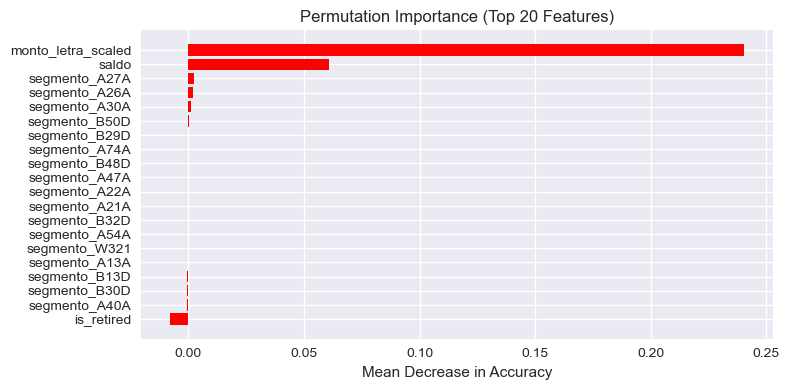

Top 20 Feature Names:
monto_letra_scaled
saldo
segmento_A27A
segmento_A26A
segmento_A30A
segmento_B50D
segmento_B29D
segmento_A74A
segmento_B48D
segmento_A47A
segmento_A22A
segmento_A21A
segmento_B32D
segmento_A54A
segmento_W321
segmento_A13A
segmento_B13D
segmento_B30D
segmento_A40A
is_retired


In [40]:
# Create the plot
plt.figure(figsize=(8, 4))

# Get the top 15 (or fewer) important features
num_features_to_plot = min(20, len(feature_importance))
top_indices = sorted_idx[-num_features_to_plot:]

# Plot only the top features
plt.barh(range(num_features_to_plot), feature_importance[top_indices],color='red')
plt.yticks(range(num_features_to_plot), [feature_names[i] for i in top_indices])
plt.xlabel('Mean Decrease in Accuracy')
plt.title('Permutation Importance (Top 20 Features)')
plt.tight_layout()
plt.show()

# Print the names of the top features
print("Top 20 Feature Names:")
for i in reversed(top_indices):
    print(feature_names[i])

In [41]:
y_test_pred_lg_class = final_model.predict(X_test[feature_selection_strategies['hybrid']])

In [43]:
test_lg_test =X_test.copy()
test_lg_test['target'] = y_test
test_lg_test ["set_type"]='test'

🎨 CREATING INCOME PREDICTION VISUALIZATION
📊 Creating Random Forest visualization...


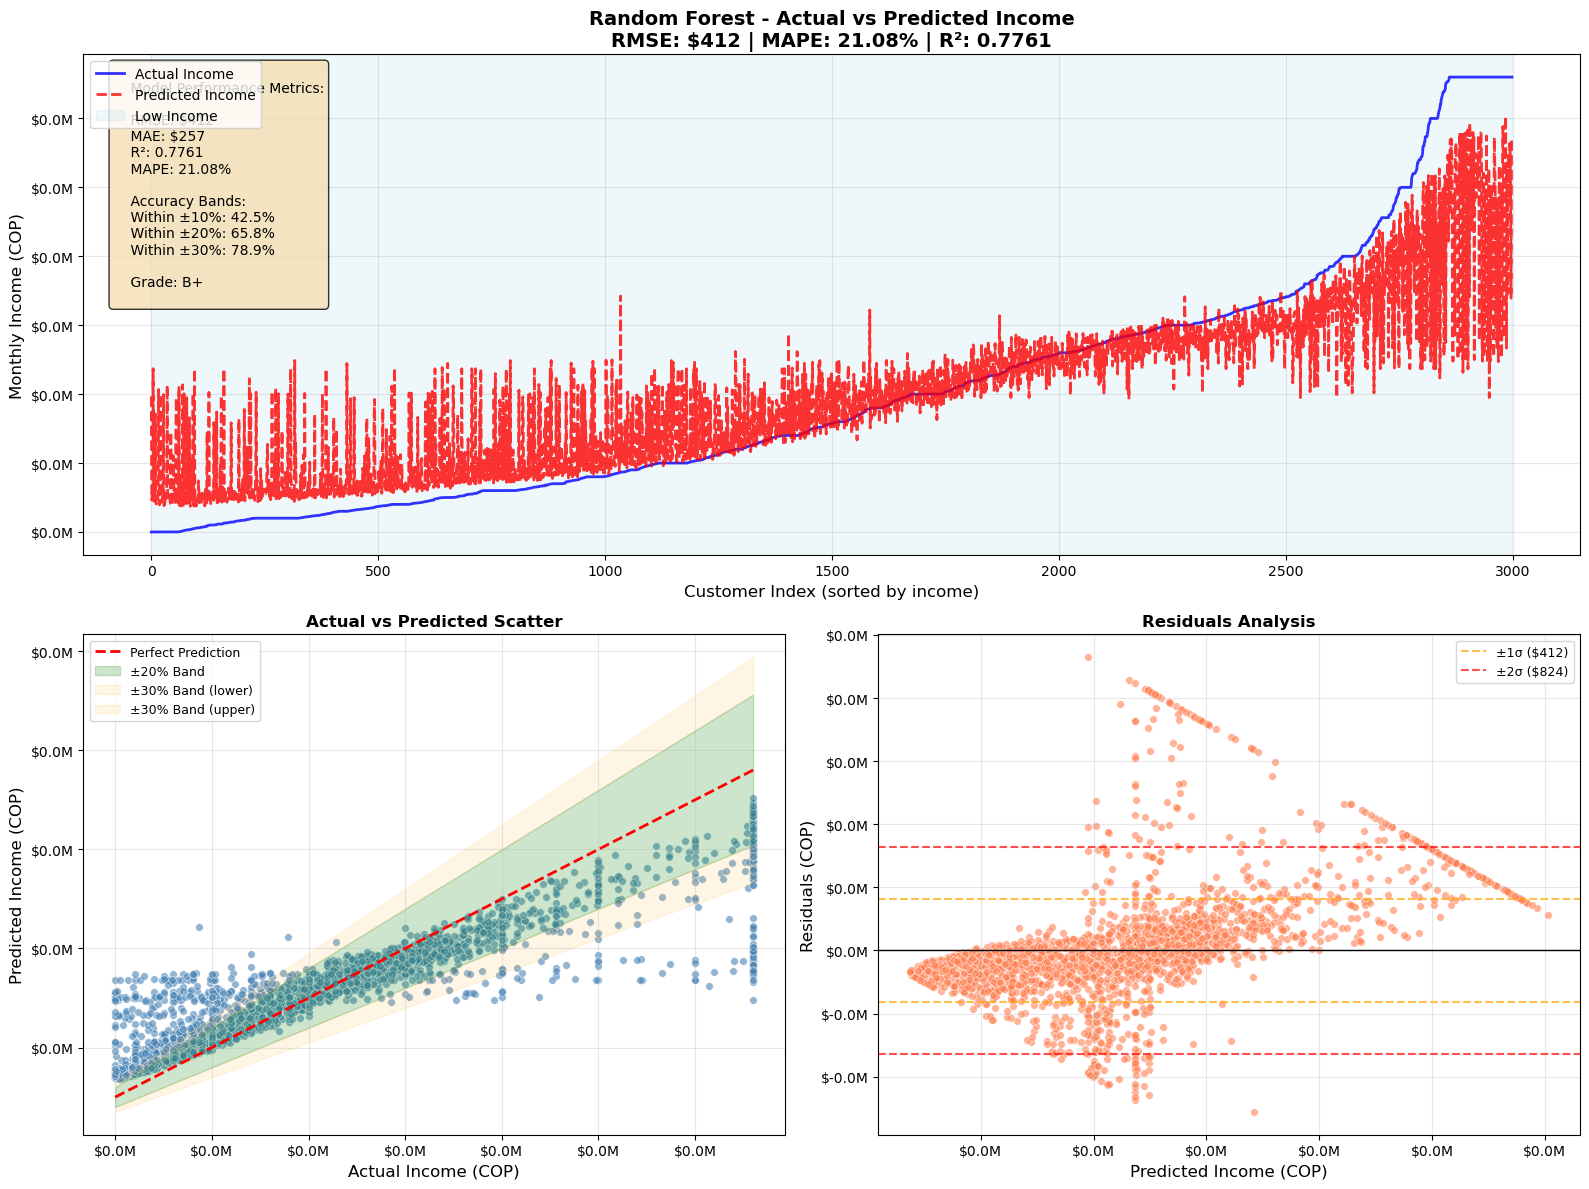

✅ Random Forest plot saved as 'income_prediction_random_forest.png'

📊 Creating LightGBM visualization...


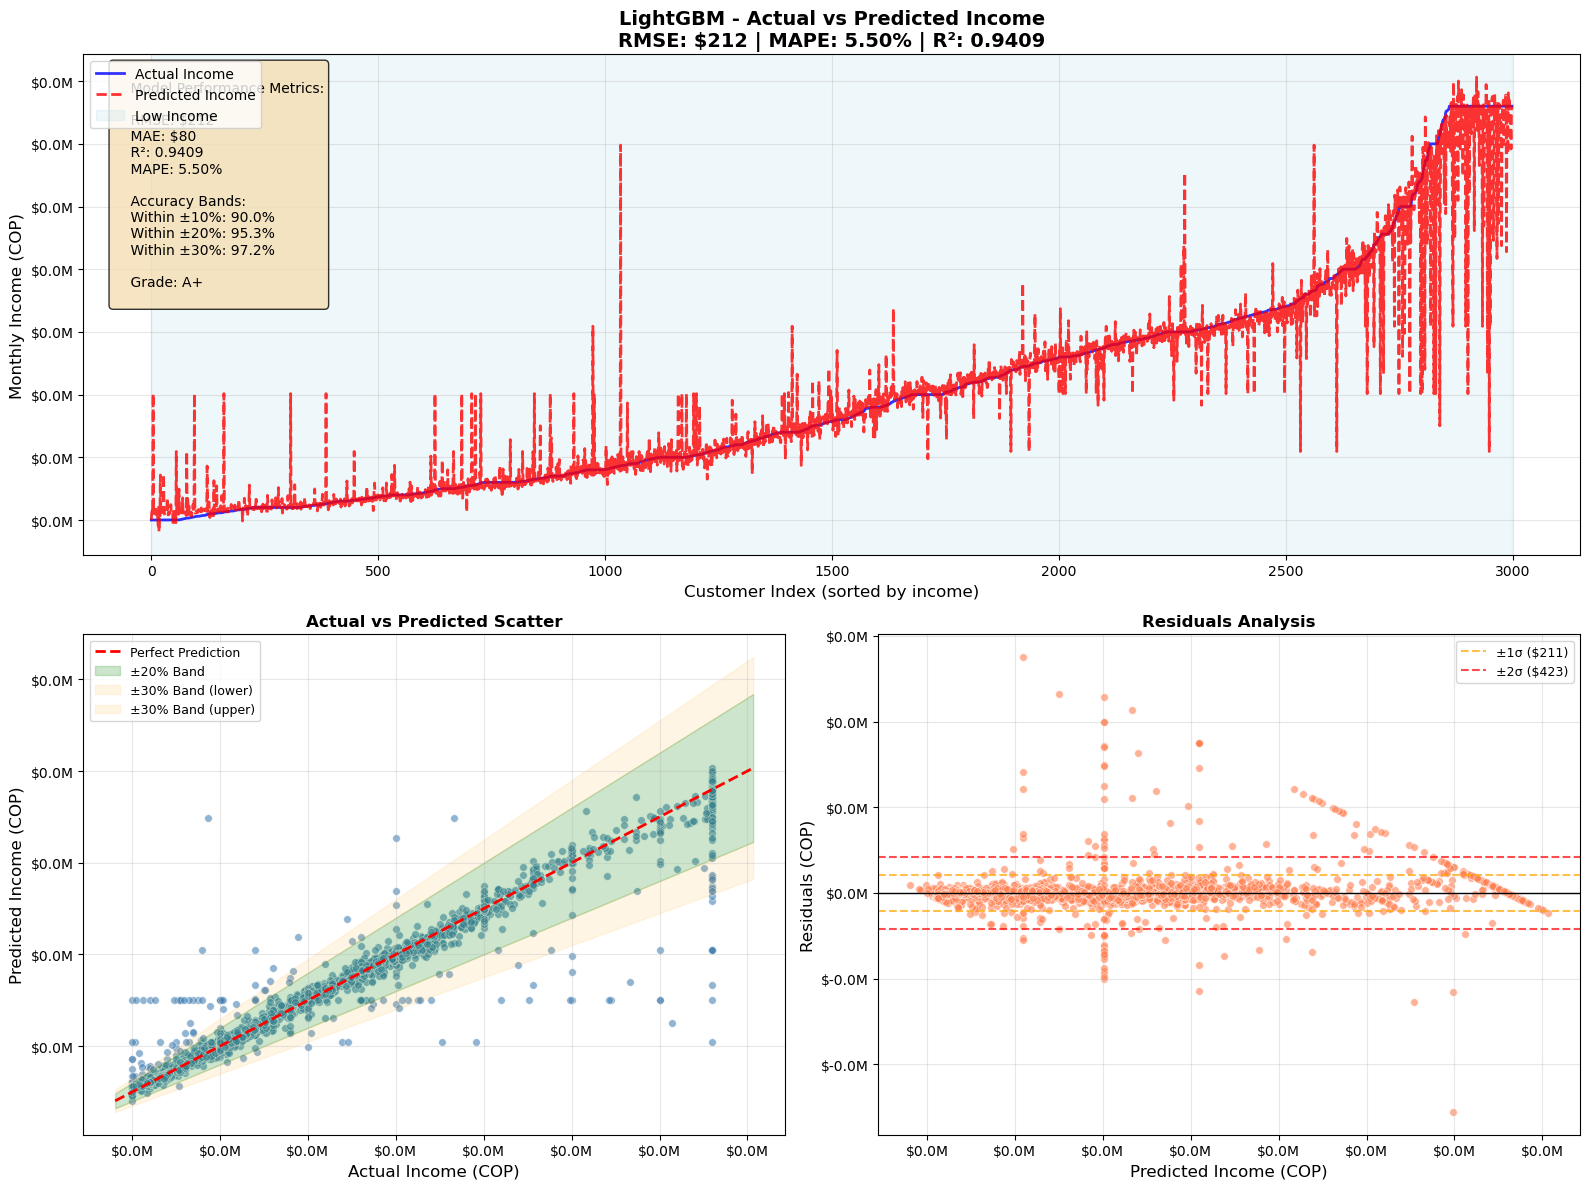

✅ LightGBM plot saved as 'income_prediction_lightgbm.png'

📊 Creating LGB_Optimized (Final Model) visualization...


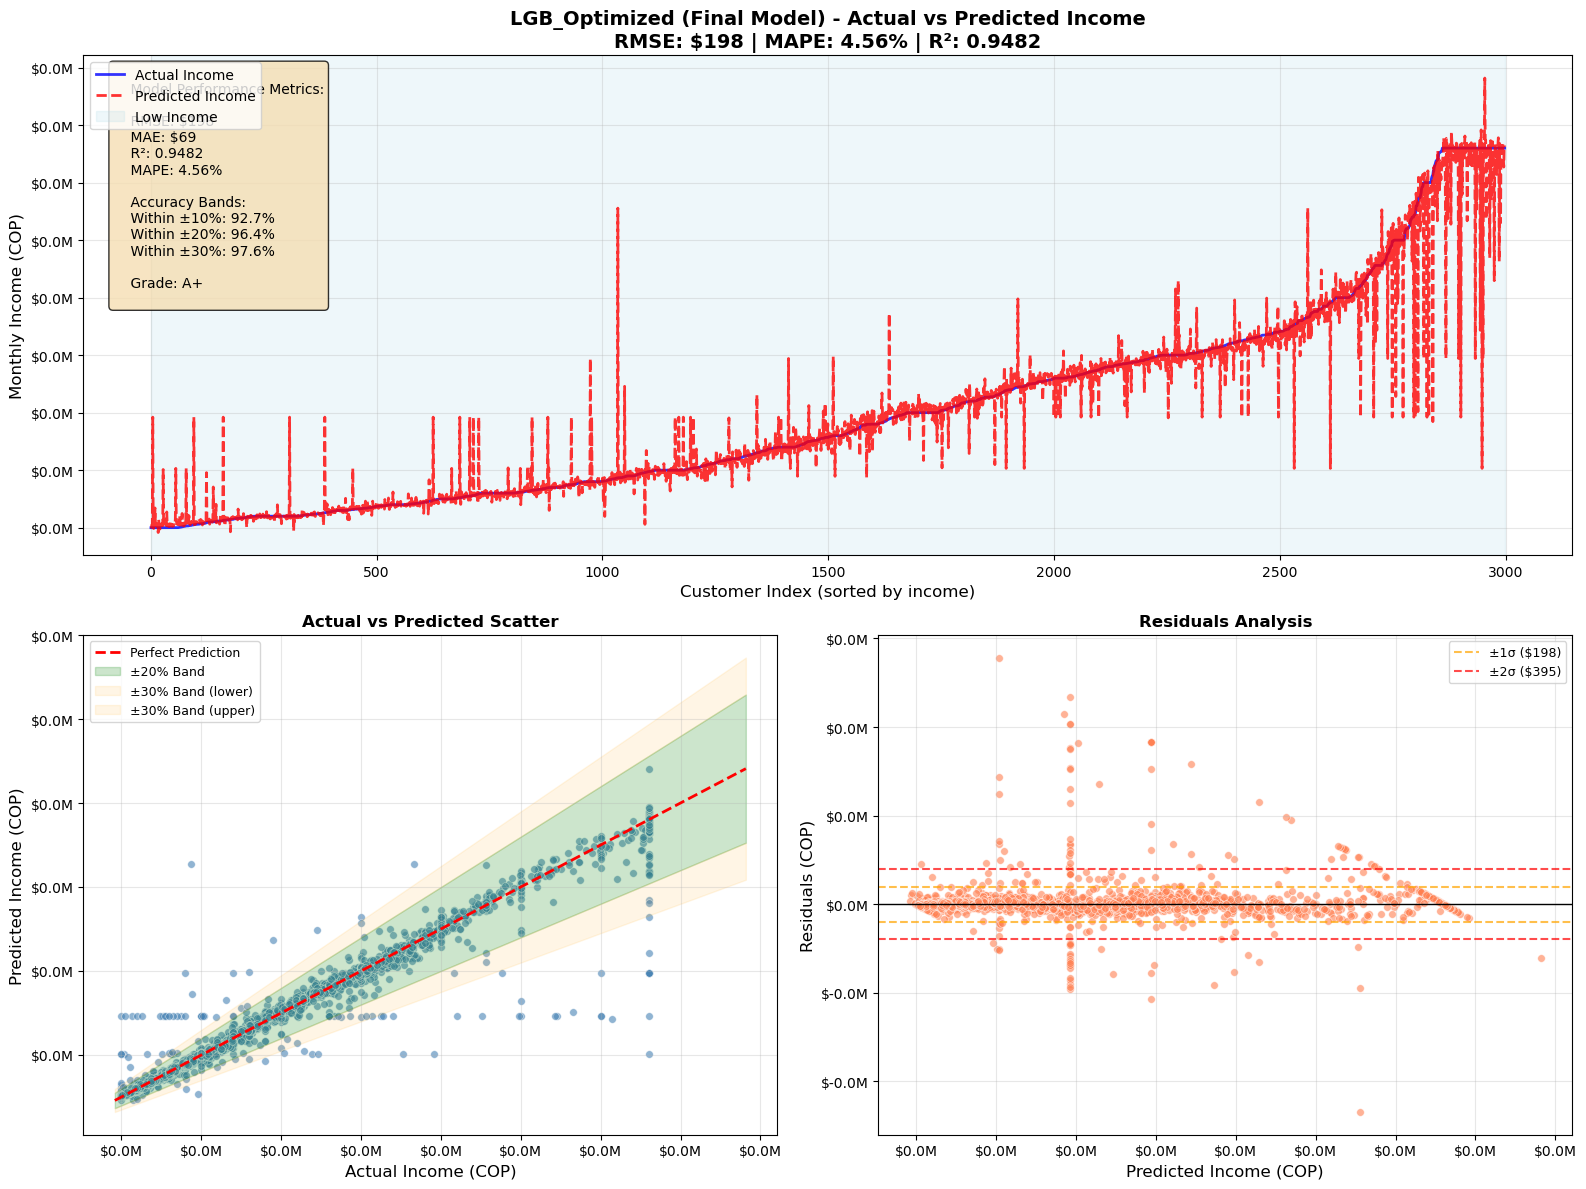

✅ Final model plot saved as 'income_prediction_final_model.png'

📊 Creating model comparison visualization...

🎉 ALL VISUALIZATIONS COMPLETED!
   📁 Check your working directory for saved PNG files
   🎨 Professional-quality plots ready for presentations


In [44]:
# ================================================================================
# INCOME ESTIMATION - ACTUAL vs PREDICTED VISUALIZATION
# ================================================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns

# Set style for professional plots
plt.style.use('default')
sns.set_palette("husl")

def create_income_prediction_plot(y_true, y_pred, X_data, model_name, metrics):
    """
    Create a comprehensive actual vs predicted plot for income estimation
    
    Parameters:
    - y_true: Actual income values
    - y_pred: Predicted income values  
    - X_data: Feature data (to extract any time-based info if available)
    - model_name: Name of the model for title
    - metrics: Dictionary with RMSE, MAE, R2, etc.
    """
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))
    
    # ============================================================================
    # MAIN PLOT: Time Series Style (even without dates)
    # ============================================================================
    
    ax1 = plt.subplot(2, 2, (1, 2))  # Top row, spanning 2 columns
    
    # Create index for x-axis (sample order)
    sample_indices = np.arange(len(y_true))
    
    # Sort by actual income for better visualization
    sort_idx = np.argsort(y_true)
    y_true_sorted = y_true.iloc[sort_idx] if hasattr(y_true, 'iloc') else y_true[sort_idx]
    y_pred_sorted = y_pred[sort_idx]
    
    # Plot actual vs predicted
    ax1.plot(sample_indices, y_true_sorted, 'b-', linewidth=2, label='Actual Income', alpha=0.8)
    ax1.plot(sample_indices, y_pred_sorted, 'r--', linewidth=2, label='Predicted Income', alpha=0.8)
    
    # Add shaded regions for different income ranges
    income_ranges = [
        (0, 1000000, 'lightblue', 'Low Income'),
        (1000000, 3000000, 'lightgreen', 'Middle Income'), 
        (3000000, 6000000, 'lightyellow', 'High Income'),
        (6000000, np.inf, 'lightcoral', 'Very High Income')
    ]
    
    for i, (min_income, max_income, color, label) in enumerate(income_ranges):
        mask = (y_true_sorted >= min_income) & (y_true_sorted < max_income)
        if mask.any():
            start_idx = np.where(mask)[0][0] if mask.any() else 0
            end_idx = np.where(mask)[0][-1] if mask.any() else len(mask)-1
            ax1.axvspan(start_idx, end_idx, alpha=0.2, color=color, label=label)
    
    # Formatting
    ax1.set_xlabel('Customer Index (sorted by income)', fontsize=12)
    ax1.set_ylabel('Monthly Income (COP)', fontsize=12)
    ax1.set_title(f'{model_name} - Actual vs Predicted Income\n'
                  f'RMSE: ${metrics["rmse"]:,.0f} | MAPE: {metrics["mape"]:.2f}% | R²: {metrics["r2"]:.4f}', 
                  fontsize=14, fontweight='bold')
    
    # Format y-axis to show currency
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    # Add grid
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left', fontsize=10)
    
    # ============================================================================
    # SCATTER PLOT: Actual vs Predicted
    # ============================================================================
    
    ax2 = plt.subplot(2, 2, 3)
    
    # Scatter plot
    ax2.scatter(y_true, y_pred, alpha=0.6, s=30, c='steelblue', edgecolors='white', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Add confidence bands (±20% and ±30%)
    x_range = np.linspace(min_val, max_val, 100)
    ax2.fill_between(x_range, x_range * 0.8, x_range * 1.2, alpha=0.2, color='green', label='±20% Band')
    ax2.fill_between(x_range, x_range * 0.7, x_range * 0.8, alpha=0.1, color='orange', label='±30% Band (lower)')
    ax2.fill_between(x_range, x_range * 1.2, x_range * 1.3, alpha=0.1, color='orange', label='±30% Band (upper)')
    
    ax2.set_xlabel('Actual Income (COP)', fontsize=12)
    ax2.set_ylabel('Predicted Income (COP)', fontsize=12)
    ax2.set_title('Actual vs Predicted Scatter', fontsize=12, fontweight='bold')
    
    # Format axes
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=9)
    
    # ============================================================================
    # RESIDUALS PLOT
    # ============================================================================
    
    ax3 = plt.subplot(2, 2, 4)
    
    # Calculate residuals
    residuals = y_true - y_pred
    
    # Residuals vs predicted
    ax3.scatter(y_pred, residuals, alpha=0.6, s=30, c='coral', edgecolors='white', linewidth=0.5)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    # Add horizontal lines for ±1 and ±2 standard deviations
    residual_std = np.std(residuals)
    ax3.axhline(y=residual_std, color='orange', linestyle='--', alpha=0.7, label=f'±1σ (${residual_std:,.0f})')
    ax3.axhline(y=-residual_std, color='orange', linestyle='--', alpha=0.7)
    ax3.axhline(y=2*residual_std, color='red', linestyle='--', alpha=0.7, label=f'±2σ (${2*residual_std:,.0f})')
    ax3.axhline(y=-2*residual_std, color='red', linestyle='--', alpha=0.7)
    
    ax3.set_xlabel('Predicted Income (COP)', fontsize=12)
    ax3.set_ylabel('Residuals (COP)', fontsize=12)
    ax3.set_title('Residuals Analysis', fontsize=12, fontweight='bold')
    
    # Format axes
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=9)
    
    # ============================================================================
    # ADD PERFORMANCE METRICS TEXT BOX
    # ============================================================================
    
    # Create text box with metrics
    metrics_text = f"""
    Model Performance Metrics:
    
    RMSE: ${metrics['rmse']:,.0f}
    MAE: ${metrics['mae']:,.0f}
    R²: {metrics['r2']:.4f}
    MAPE: {metrics['mape']:.2f}%
    
    Accuracy Bands:
    Within ±10%: {metrics['within_10pct']:.1f}%
    Within ±20%: {metrics['within_20pct']:.1f}%
    Within ±30%: {metrics['within_30pct']:.1f}%
    
    Grade: {metrics['grade']}
    """
    
    # Add text box to the main plot
    ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    return fig

# ================================================================================
# CREATE THE PLOT FOR YOUR MODELS
# ================================================================================

print("🎨 CREATING INCOME PREDICTION VISUALIZATION")
print("=" * 60)

# For Random Forest model
if 'rf_model' in locals() and 'rf_val_metrics' in locals():
    print("📊 Creating Random Forest visualization...")
    
    fig_rf = create_income_prediction_plot(
        y_true=y_val,
        y_pred=rf_predictions_val,
        X_data=X_val_scaled,
        model_name="Random Forest",
        metrics=rf_val_metrics
    )
    
    plt.show()
    
    # Save the plot
    fig_rf.savefig('income_prediction_random_forest.png', dpi=300, bbox_inches='tight')
    print("✅ Random Forest plot saved as 'income_prediction_random_forest.png'")

# For LightGBM model
if 'lgb_model' in locals() and 'lgb_val_metrics' in locals():
    print("\n📊 Creating LightGBM visualization...")
    
    fig_lgb = create_income_prediction_plot(
        y_true=y_val,
        y_pred=lgb_predictions_val,
        X_data=X_val_scaled,
        model_name="LightGBM",
        metrics=lgb_val_metrics
    )
    
    plt.show()
    
    # Save the plot
    fig_lgb.savefig('income_prediction_lightgbm.png', dpi=300, bbox_inches='tight')
    print("✅ LightGBM plot saved as 'income_prediction_lightgbm.png'")

# For the final/best model
if 'final_model' in locals() and 'final_metrics' in locals():
    print(f"\n📊 Creating {final_model_name} (Final Model) visualization...")
    
    # Get predictions for final model
    final_predictions_val = final_model.predict(X_val_scaled)
    
    fig_final = create_income_prediction_plot(
        y_true=y_val,
        y_pred=final_predictions_val,
        X_data=X_val_scaled,
        model_name=f"{final_model_name} (Final Model)",
        metrics=final_metrics
    )
    
    plt.show()
    
    # Save the plot
    fig_final.savefig('income_prediction_final_model.png', dpi=300, bbox_inches='tight')
    print(f"✅ Final model plot saved as 'income_prediction_final_model.png'")

# ================================================================================
# BONUS: COMPARISON PLOT
# ================================================================================

def create_model_comparison_plot():
    """Create a side-by-side comparison of both models"""
    
    if 'rf_predictions_val' in locals() and 'lgb_predictions_val' in locals():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Random Forest
        sample_indices = np.arange(len(y_val))
        sort_idx = np.argsort(y_val)
        y_true_sorted = y_val.iloc[sort_idx] if hasattr(y_val, 'iloc') else y_val[sort_idx]
        rf_pred_sorted = rf_predictions_val[sort_idx]
        lgb_pred_sorted = lgb_predictions_val[sort_idx]
        
        # Plot RF
        ax1.plot(sample_indices, y_true_sorted, 'b-', linewidth=2, label='Actual Income', alpha=0.8)
        ax1.plot(sample_indices, rf_pred_sorted, 'r--', linewidth=2, label='RF Predicted', alpha=0.8)
        ax1.set_title(f'Random Forest\nRMSE: ${rf_val_metrics["rmse"]:,.0f} | R²: {rf_val_metrics["r2"]:.4f}', 
                     fontsize=14, fontweight='bold')
        ax1.set_xlabel('Customer Index (sorted by income)')
        ax1.set_ylabel('Monthly Income (COP)')
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot LGB
        ax2.plot(sample_indices, y_true_sorted, 'b-', linewidth=2, label='Actual Income', alpha=0.8)
        ax2.plot(sample_indices, lgb_pred_sorted, 'g--', linewidth=2, label='LGB Predicted', alpha=0.8)
        ax2.set_title(f'LightGBM\nRMSE: ${lgb_val_metrics["rmse"]:,.0f} | R²: {lgb_val_metrics["r2"]:.4f}', 
                     fontsize=14, fontweight='bold')
        ax2.set_xlabel('Customer Index (sorted by income)')
        ax2.set_ylabel('Monthly Income (COP)')
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Save comparison
        fig.savefig('income_prediction_model_comparison.png', dpi=300, bbox_inches='tight')
        print("✅ Model comparison plot saved as 'income_prediction_model_comparison.png'")
        
        return fig

# Create comparison plot
if 'rf_predictions_val' in locals() and 'lgb_predictions_val' in locals():
    print("\n📊 Creating model comparison visualization...")
    comparison_fig = create_model_comparison_plot()

print(f"\n🎉 ALL VISUALIZATIONS COMPLETED!")
print(f"   📁 Check your working directory for saved PNG files")
print(f"   🎨 Professional-quality plots ready for presentations")